In [2]:
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

import numpy as np
import matplotlib.pyplot as plt

import collections
import os

import logging
import pickle
from tqdm import tqdm

logger = logging.getLogger(__name__)

import networkx as nx
seed = 20160  # seed random number generators for reproducibility

In [82]:
#sub-gaussian 
class Environment:
    def __init__(self, config):
        self.T = config['T']
        self.M = config['M']
        self.c = config['c']

        self.mu = config['mu']
        self.sigma = config['sigma']
        self.h = config['h']
        #self.mu_opt_M = np.sort(self.mu)[-self.M:]
        self.K = config['K']
        logger.info(f"Created environment with M = {self.M}, mu = {self.mu},h= {self.h}, T = {self.T}, K = {self.K}")

    def __str__(self):
        return f"M{self.M}-K{self.K}-mu{str(self.mu)}"

    def update(self, t):
        pass

    def draw(self, arms, sensing=False):
        counts = collections.Counter(arms)
        rewards = np.zeros((self.M,))
        for player in range(self.M):
            #rewards[player] = np.random.normal(self.mu[player,arms[player]], self.sigma[player, arms[player]])
            if np.random.rand() <= self.mu[player,arms[player]]:
                rewards[player]=1
            else:
                rewards[player]=0
            #rewards[player] = np.random.binomial(1, self.mu[player,arms[player]], 1)
        graph = nx.erdos_renyi_graph(self.M,self.c,seed)


        return rewards, graph

class LocalMAB:
    def __init__(self, num_agents, num_arms):
        self.num_arms = num_arms
        #self.true_reward_means = true_reward_means
        self.q_local = np.zeros(num_arms)  # Estimated action values
        self.q_network = np.zeros(num_arms)  # Estimated action values
        self.q_var = np.zeros(num_arms)
        self.counts_local = np.zeros(num_arms)  # Counts of each action taken
        self.counts_network = np.zeros(num_arms)  # Counts of each action taken
        self.total_reward = 0
        self.c1 = 4
        self.c2 = 0
        self.epsilon = 0.1  # Exploration rate
        self.P = np.zeros(num_agents)
        self.P1 = np.zeros(num_agents)
        self.ucb = 0
        self.M = num_agents
        self.comm_reward = {}
        self.comm_counts = {}
        self.comm_reward_network = {}
        self.comm_counts_network = {}
        self.tmp = {}
        self.exp_reward = 0
        self.exp_reward_list = []
        self.regret = 0
        self.regret_list = []


    def choose_action(self, t, flag, c1):
        if flag:  # Corrected condition
            # Explore with probability epsilon
            return np.random.choice(self.num_arms)
        else:
            # Exploit the current estimates
            #self.counts_local[i]
            self.q_var = [np.sqrt(c1*np.log(t)/self.counts_network[i]) for i in range(len(self.counts_local))]
            self.ucb = [(self.q_network[i]+ self.q_var[i]) for i in range(len(self.q_network))]
            return np.argmax(self.ucb)

    def update(self, chosen_action, reward, exp_reward):
        # Update action values using sample-average method
        self.counts_local[chosen_action] += 1
        self.q_local[chosen_action] = (reward + self.q_local[chosen_action]*(self.counts_local[chosen_action]-1)) / self.counts_local[chosen_action]  # Corrected action counts
        self.total_reward += reward
        self.exp_reward += exp_reward
        self.exp_reward_list.append(self.exp_reward)
    
    def update_global(self, chosen_action, reward):
        # Update action values using sample-average method
        #self.counts_local[chosen_action] += 1
        a = 0
        for i in range(self.num_arms):  # Corrected loop
            for j in range(self.M):
                if self.P[j] >0:
                    a = max(self.comm_counts[j][i], a)  # Corrected assignment
            self.counts_network[i] = max(a, self.counts_local[i])
        #self.q_local[chosen_action] += (reward - self.q_local[chosen_action]) / self.counts_local[chosen_action]  # Corrected action counts
        for i in range(config['M']):
            d = (1 - np.sum(bandit[i].P1))/config['M']
            for k in range(config['K']):
                bandit[i].q_network[k] = sum([(bandit[i].P1[j] * bandit[i].comm_reward_network[j][k] + d*bandit[i].comm_reward[j][k]) for j in bandit[i].comm_reward])


In [83]:
def main(M,c,K,h):
    #Simulation
    # different h, K, M, mu, sigma, c  
    # when c is not 0, 
    config = {}
    config['T'] = 2000
    config['L'] = 100
    config['M'] = M
    config['c'] = c
    config['K'] = K
    config['c1'] = 5
    config['h'] = h
    config['scale'] = 0.2
    config['mu'] = np.ones((config['M'], config['K']))
    print(config['mu'])
    for k in range(config['K']):
        config['mu'][:,k] = np.linspace(0.1,0.1+(k+1)*config['h']/config['K'],config['M'])
    config['sigma'] = config['scale']*np.ones((config['M'], config['K']))
    mu = config['mu']
    #mu = np.array(sorted(mu, reverse=True))
    print(mu)
    #bandit = MultiArmedBandit(num_arms, true_reward_means)
    T = config['T']
    num_agents =config['M']
    L = config['L']
    para = 0.6
    tau = 1
    #P = np.zeros((num_agents, num_arms))
    environment = Environment(config)
    #print(num_arms)
    itr = 20
    avg_regret = []
    for iteration in range(itr):
        bandit = []
        for player in range(config['M']):
            bandit.append(LocalMAB(num_agents, config['K']))

        #burn-in period  
        for t in range(L):
            arms = []
            for player in range(config['M']):
                chosen_action = t % config['K'] 
                arms.append(chosen_action)
            reward, G = environment.draw(arms)  # Simulate reward with Gaussian noise
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            for i in range(len(neighbors)):
                tmp = np.zeros(len(neighbors))
                neighbors[i].append(i)
                for j in range(len(neighbors)):
                    if j in neighbors[i]:
                        tmp[j] = 1
                        neighbors[j].append(i)
                        bandit[i].comm_reward[j] = bandit[j].q_local
                        bandit[i].comm_counts[j] = bandit[j].counts_local
                        bandit[i].tmp[j] = t
                    else:
                        tmp[j] = 0
                if t > 0:
                    bandit[i].P = [((t-1)*bandit[i].P[j] + tmp[j])/t for j in range(config['M'])]
                else:
                    bandit[i].P = tmp 
                for j in range(len(neighbors)):
                    if bandit[i].P[j] > 0:
                        bandit[i].P1[j] = 1/config['M']
                    else:
                        bandit[i].P1[j] = 0
            for i in range(config['M']):
                bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
                bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
                bandit[i].regret_list.append(bandit[i].regret)

        for k in range(config['K']):
            for i in range(config['M']):
                bandit[i].q_network[k] = sum([((config['M']/len(bandit[i].comm_reward))*bandit[i].P1[j] * bandit[i].comm_reward[j][k]) for j in bandit[i].comm_reward])

        i = 0
        #print("Estimated action values:", bandit[i].q_network)
        #print("Total reward:", bandit[i].total_reward)
        #print("maintained matrix:", bandit[i].P)

        #learning period 
        r = 0
        for t in range(L, T):
            arms = []
            for i in range(config['M']):
                flag = False
                for k in range(config['K']):
                    if bandit[i].counts_local[k] < bandit[i].counts_network[k] - config['K']:
                        flag = True
                chosen_action = bandit[i].choose_action(t, flag,config['c1'])
                arms.append(chosen_action)
                if chosen_action == 0:
                    r+=1
            reward, G = environment.draw(arms)  # Simulate reward with Gaussian noise
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            for i in range(len(neighbors)):
                tmp = np.zeros(len(neighbors))
                neighbors[i].append(i)
                for j in range(len(neighbors)):
                    if j in neighbors[i]:
                        tmp[j] = 1
                        neighbors[j].append(i)
                        bandit[i].comm_reward[j] = bandit[j].q_local
                        bandit[i].comm_counts[j] = bandit[j].counts_local
                        bandit[i].comm_reward_network[j] = bandit[j].q_network
                        bandit[i].comm_counts_network[j] = bandit[j].counts_network
                        bandit[i].tmp[j] = t
                    else:
                        tmp[j] = 0
                if t > 0:
                    bandit[i].P = [((t-1)*bandit[i].P[j] + tmp[j])/t for j in range(config['M'])]
                else:
                    bandit[i].P = tmp 
                for j in range(len(neighbors)):
                    if bandit[i].P[j] > 0:
                        bandit[i].P1[j] = (config['M'])/((config['M'])**2)
                    else:
                        bandit[i].P1[j] = 0
            for i in range(config['M']):
                bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
                bandit[i].update_global(arms[i], reward[i])
                bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
                bandit[i].regret_list.append(bandit[i].regret)
        regret_t = [np.mean([bandit[i].regret_list[j] for i in range(config['M'])]) for j in range(len(bandit[1].regret_list))]
        avg_regret.append(regret_t)
        
        return avg_regret



In [94]:
c_set = [0.7, 0.8, 0.9]
avg_regret_list = []
for c in c_set:
    tmp_regret = main(5,c, 2, 0.1)
    avg_regret_list.append(tmp_regret)

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1    0.1   ]
 [0.1125 0.125 ]
 [0.125  0.15  ]
 [0.1375 0.175 ]
 [0.15   0.2   ]]


/var/folders/tt/xtqbgt9s3pv16nh1_s_q2zc80000gn/T/ipykernel_51490/2909422124.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  self.q_var = [np.sqrt(c1*np.log(t)/self.counts_network[i]) for i in range(len(self.counts_local))]


[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1    0.1   ]
 [0.1125 0.125 ]
 [0.125  0.15  ]
 [0.1375 0.175 ]
 [0.15   0.2   ]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1    0.1   ]
 [0.1125 0.125 ]
 [0.125  0.15  ]
 [0.1375 0.175 ]
 [0.15   0.2   ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


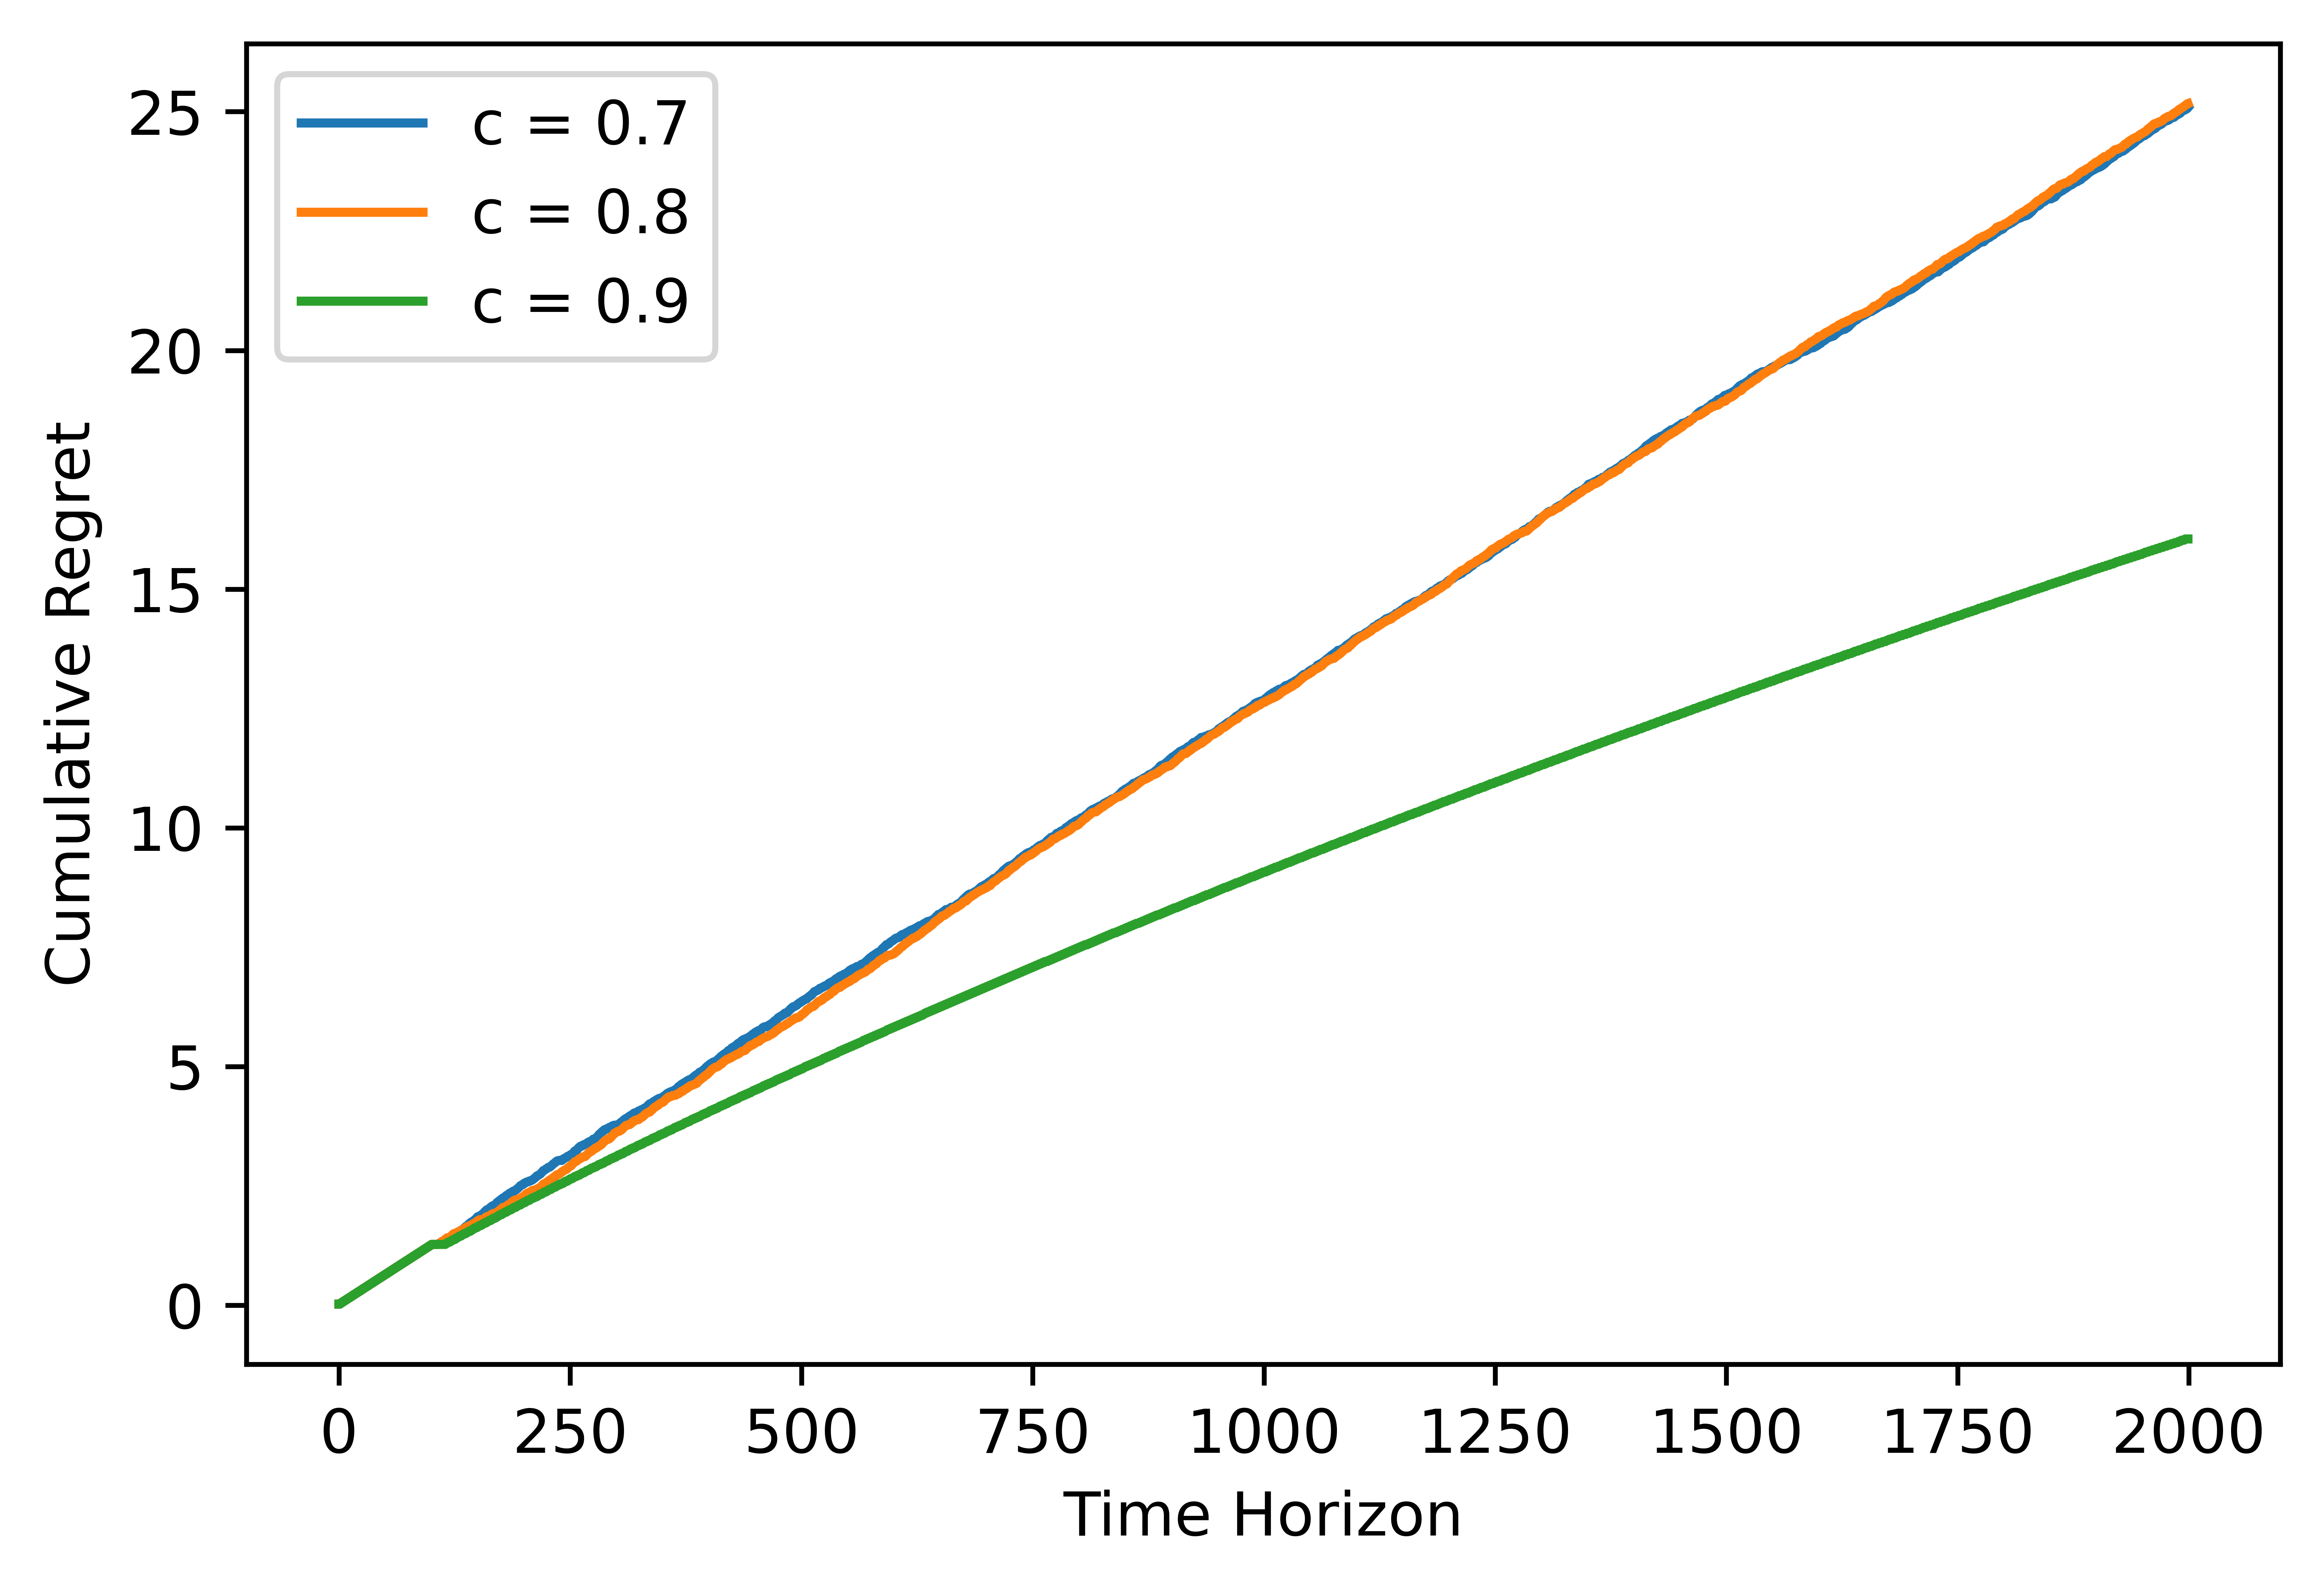

In [97]:
#regret_t = [sum(bandit[i].[j])/2 for j in range(len(bandit[1].regret_list))]
#print(len(avg_regret))
#regret_final = [np.mean([avg_regret[i][k] for i in range(len(avg_regret))]) for k in range(config['T'])]
x=np.arange(2000)

#print(avg_regret)

plt.figure(dpi=1200)


plot_data = np.transpose(np.array(avg_regret_list)).reshape((2000,3))
#x_axis = np.arange(len(plot_data))
plt.plot(x,plot_data)
# plt.plot(x_axis,plot_min)
# plt.plot(x_axis,plot_max)
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.legend(['c = 0.7','c = 0.8','c = 0.9'])

In [108]:
K_set = [3, 4, 5]
avg_regret_list = []
for k in K_set:
    tmp_regret = main(5,0.95, k, 0.1)
    avg_regret_list.append(tmp_regret)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[[0.1        0.1        0.1       ]
 [0.10833333 0.11666667 0.125     ]
 [0.11666667 0.13333333 0.15      ]
 [0.125      0.15       0.175     ]
 [0.13333333 0.16666667 0.2       ]]
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[[0.1     0.1     0.1     0.1    ]
 [0.10625 0.1125  0.11875 0.125  ]
 [0.1125  0.125   0.1375  0.15   ]
 [0.11875 0.1375  0.15625 0.175  ]
 [0.125   0.15    0.175   0.2    ]]


/var/folders/tt/xtqbgt9s3pv16nh1_s_q2zc80000gn/T/ipykernel_51490/2909422124.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  self.q_var = [np.sqrt(c1*np.log(t)/self.counts_network[i]) for i in range(len(self.counts_local))]


[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
[[0.1   0.1   0.1   0.1   0.1  ]
 [0.105 0.11  0.115 0.12  0.125]
 [0.11  0.12  0.13  0.14  0.15 ]
 [0.115 0.13  0.145 0.16  0.175]
 [0.12  0.14  0.16  0.18  0.2  ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


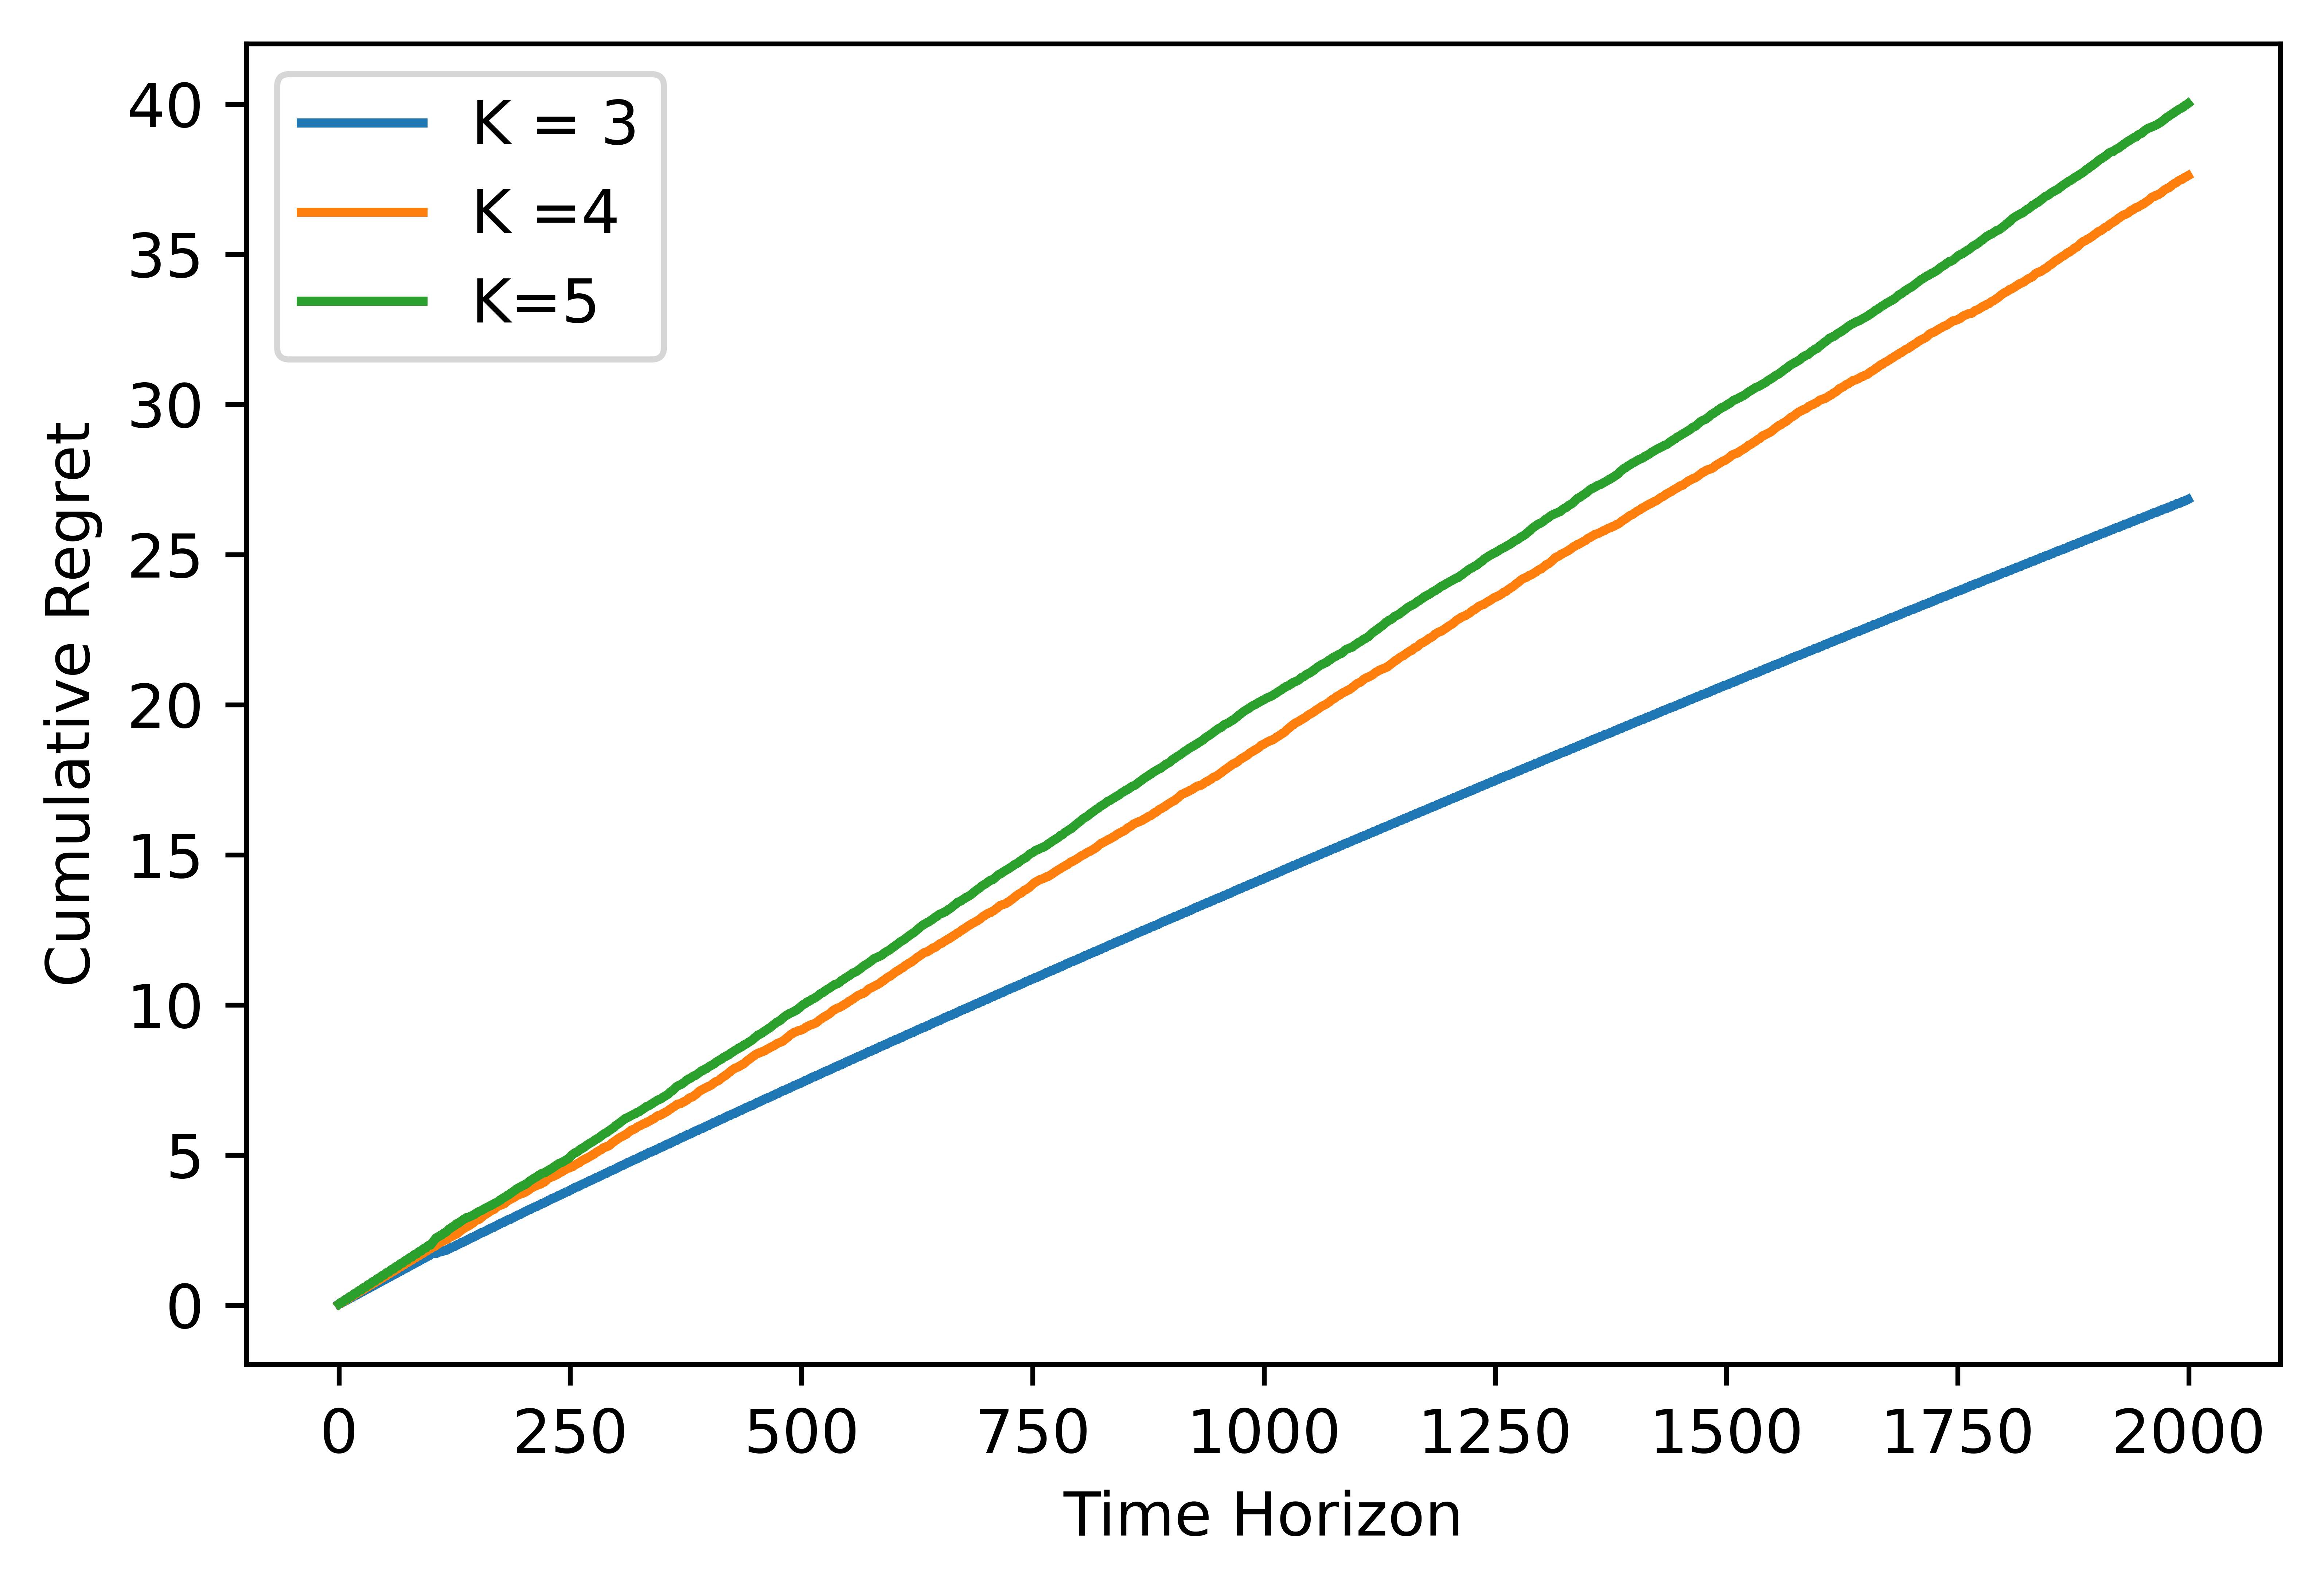

In [109]:
#regret_t = [sum(bandit[i].[j])/2 for j in range(len(bandit[1].regret_list))]
#print(len(avg_regret))
#regret_final = [np.mean([avg_regret[i][k] for i in range(len(avg_regret))]) for k in range(config['T'])]
x=np.arange(2000)

#print(avg_regret)

plt.figure(dpi=1200)


plot_data = np.transpose(np.array(avg_regret_list)).reshape((2000,3))
#x_axis = np.arange(len(plot_data))
plt.plot(x,plot_data)
# plt.plot(x_axis,plot_min)
# plt.plot(x_axis,plot_max)
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.legend(['K = 3','K =4','K=5'])

In [131]:
M_set = [3, 5, 8, 10]
avg_regret_list = []
for M in M_set:
    tmp_regret = main(M,0.9, 2, 0.1)
    avg_regret_list.append(tmp_regret)

[[1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1   0.1  ]
 [0.125 0.15 ]
 [0.15  0.2  ]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1    0.1   ]
 [0.1125 0.125 ]
 [0.125  0.15  ]
 [0.1375 0.175 ]
 [0.15   0.2   ]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1        0.1       ]
 [0.10714286 0.11428571]
 [0.11428571 0.12857143]
 [0.12142857 0.14285714]
 [0.12857143 0.15714286]
 [0.13571429 0.17142857]
 [0.14285714 0.18571429]
 [0.15       0.2       ]]


/var/folders/tt/xtqbgt9s3pv16nh1_s_q2zc80000gn/T/ipykernel_51490/2909422124.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  self.q_var = [np.sqrt(c1*np.log(t)/self.counts_network[i]) for i in range(len(self.counts_local))]


[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1        0.1       ]
 [0.10555556 0.11111111]
 [0.11111111 0.12222222]
 [0.11666667 0.13333333]
 [0.12222222 0.14444444]
 [0.12777778 0.15555556]
 [0.13333333 0.16666667]
 [0.13888889 0.17777778]
 [0.14444444 0.18888889]
 [0.15       0.2       ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4


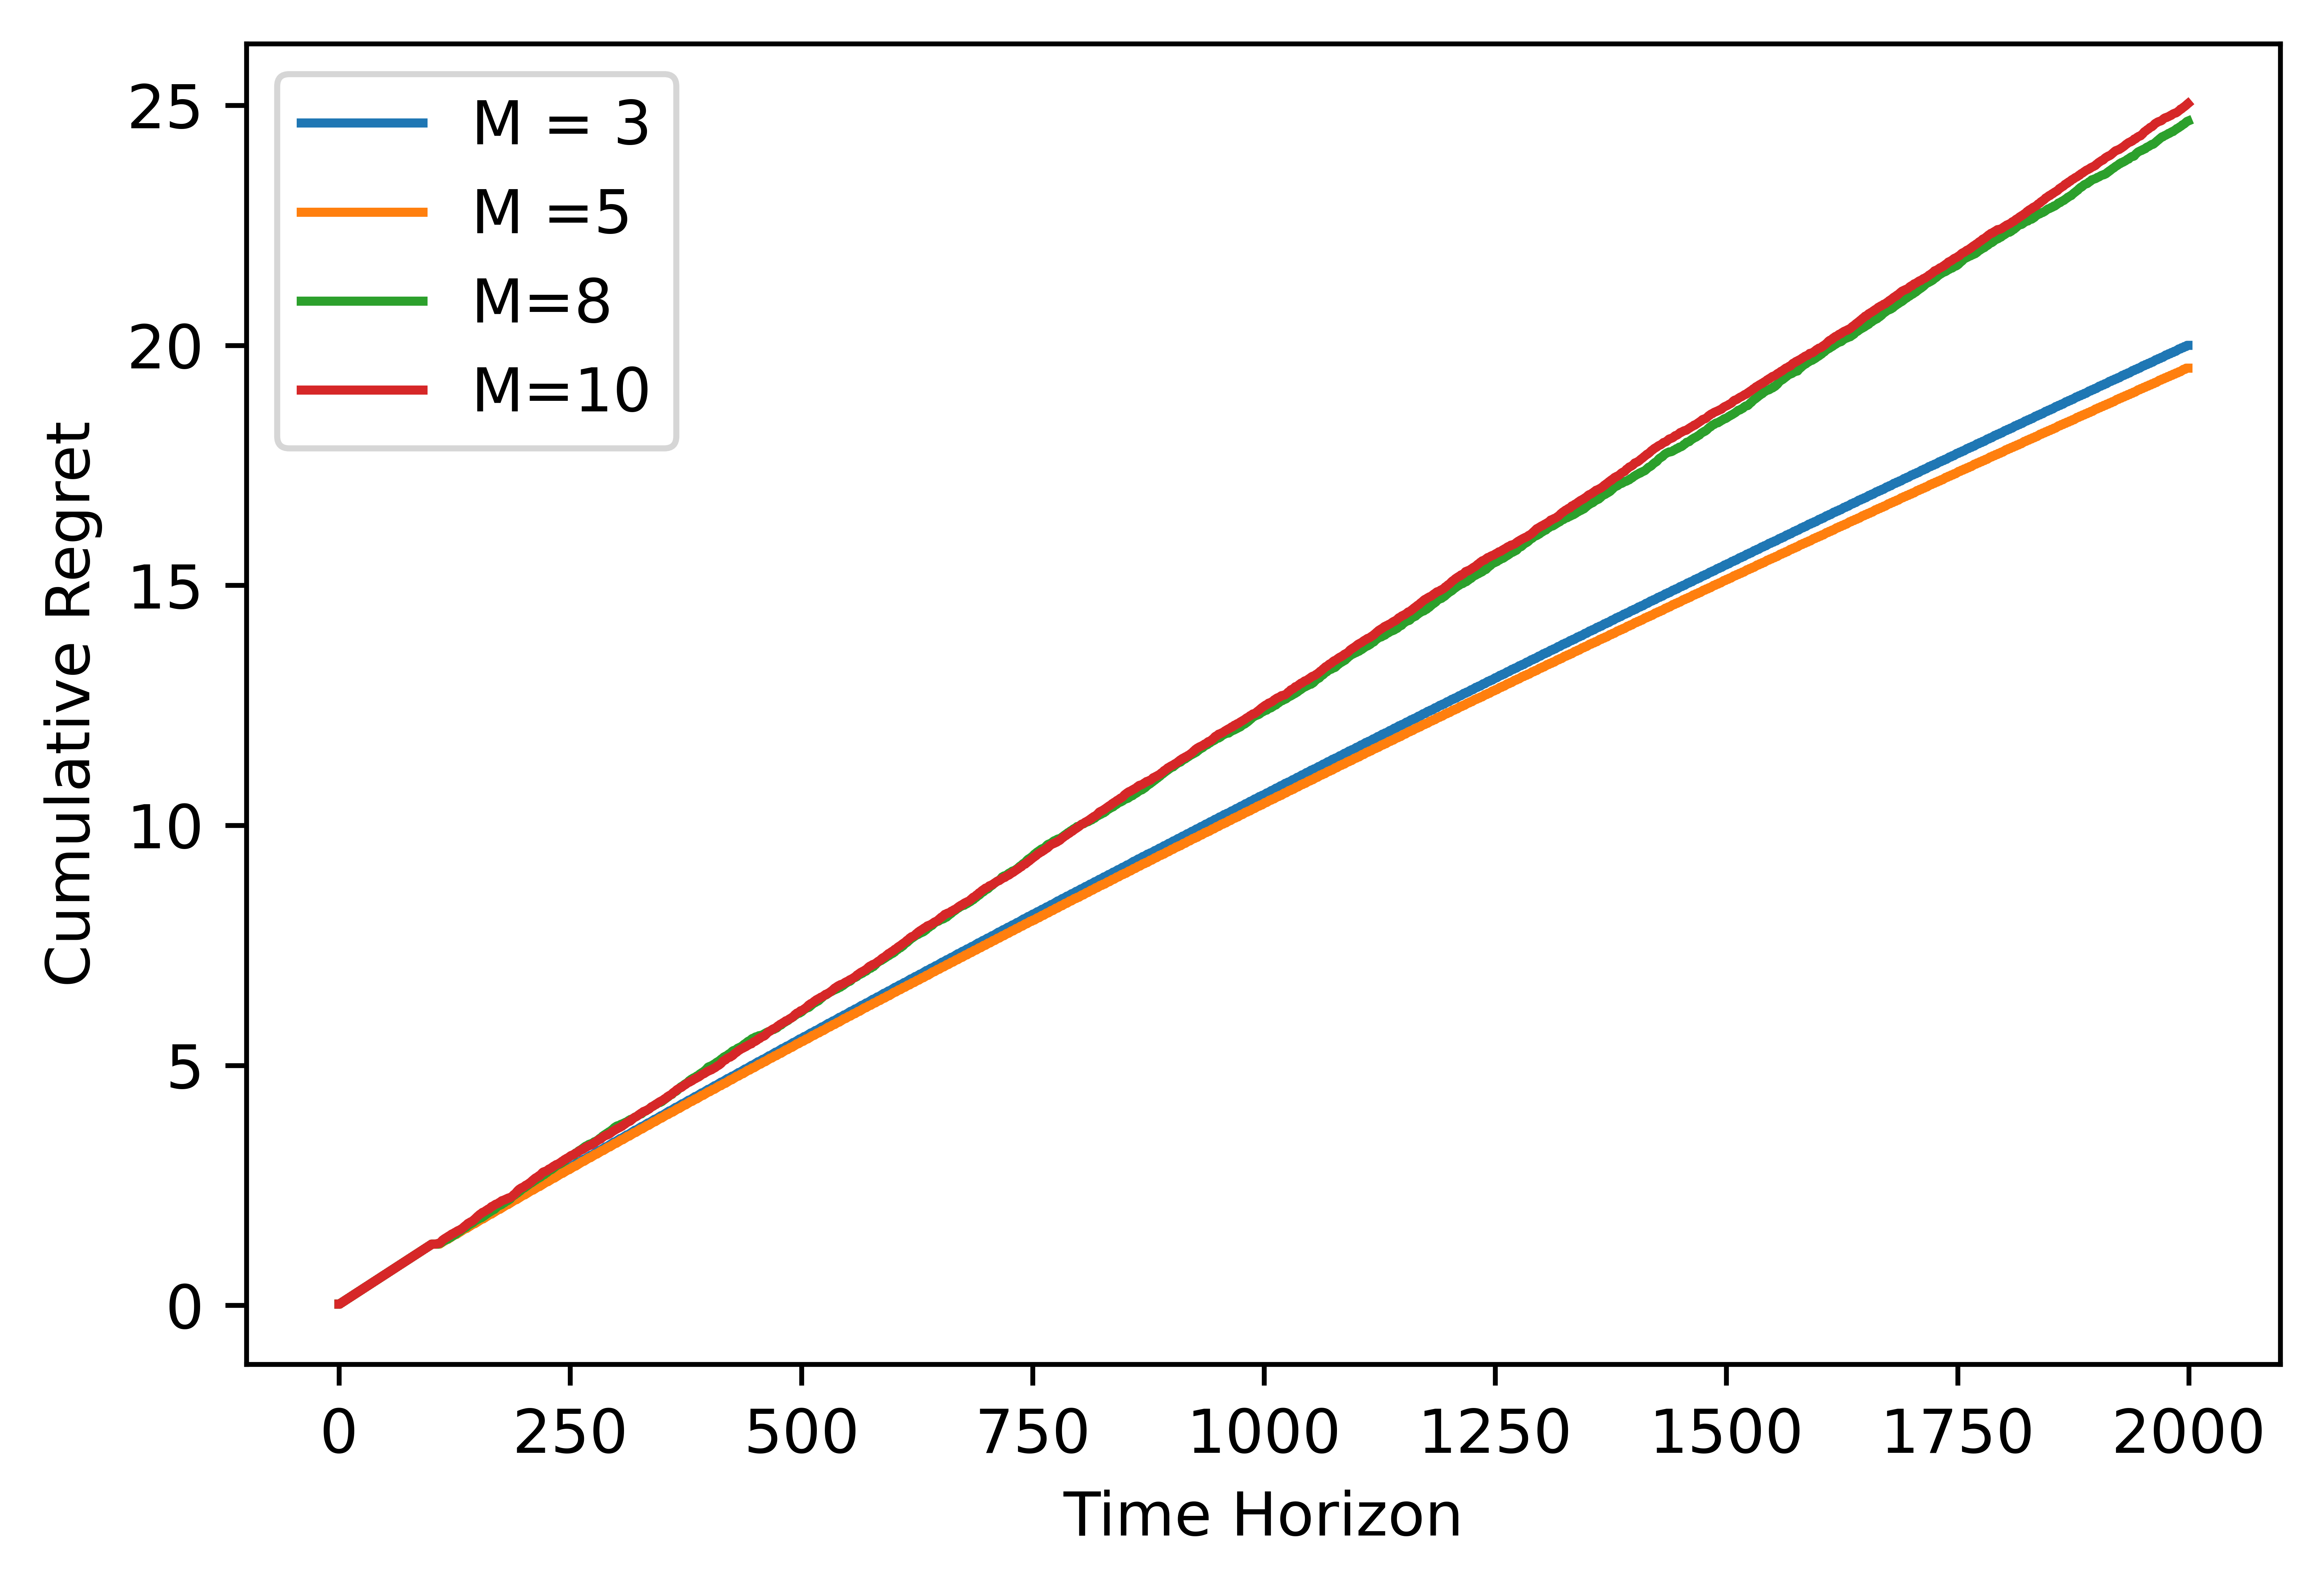

In [132]:
#regret_t = [sum(bandit[i].[j])/2 for j in range(len(bandit[1].regret_list))]
#print(len(avg_regret))
#regret_final = [np.mean([avg_regret[i][k] for i in range(len(avg_regret))]) for k in range(config['T'])]
x=np.arange(2000)

#print(avg_regret)

plt.figure(dpi=1200)
print(len(avg_regret_list))

plot_data = np.transpose(np.array(avg_regret_list)).reshape((2000,4))
#x_axis = np.arange(len(plot_data))
plt.plot(x,plot_data)
# plt.plot(x_axis,plot_min)
# plt.plot(x_axis,plot_max)
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.legend(['M = 3','M =5','M=8', 'M=10'])

In [134]:
h_set = [0.1,0.2,0.3]
avg_regret_list = []
for h in h_set:
    tmp_regret = main(5,0.9, 2, h)
    avg_regret_list.append(tmp_regret)

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1    0.1   ]
 [0.1125 0.125 ]
 [0.125  0.15  ]
 [0.1375 0.175 ]
 [0.15   0.2   ]]


/var/folders/tt/xtqbgt9s3pv16nh1_s_q2zc80000gn/T/ipykernel_51490/2909422124.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  self.q_var = [np.sqrt(c1*np.log(t)/self.counts_network[i]) for i in range(len(self.counts_local))]


[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1   0.1  ]
 [0.125 0.15 ]
 [0.15  0.2  ]
 [0.175 0.25 ]
 [0.2   0.3  ]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1    0.1   ]
 [0.1375 0.175 ]
 [0.175  0.25  ]
 [0.2125 0.325 ]
 [0.25   0.4   ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3


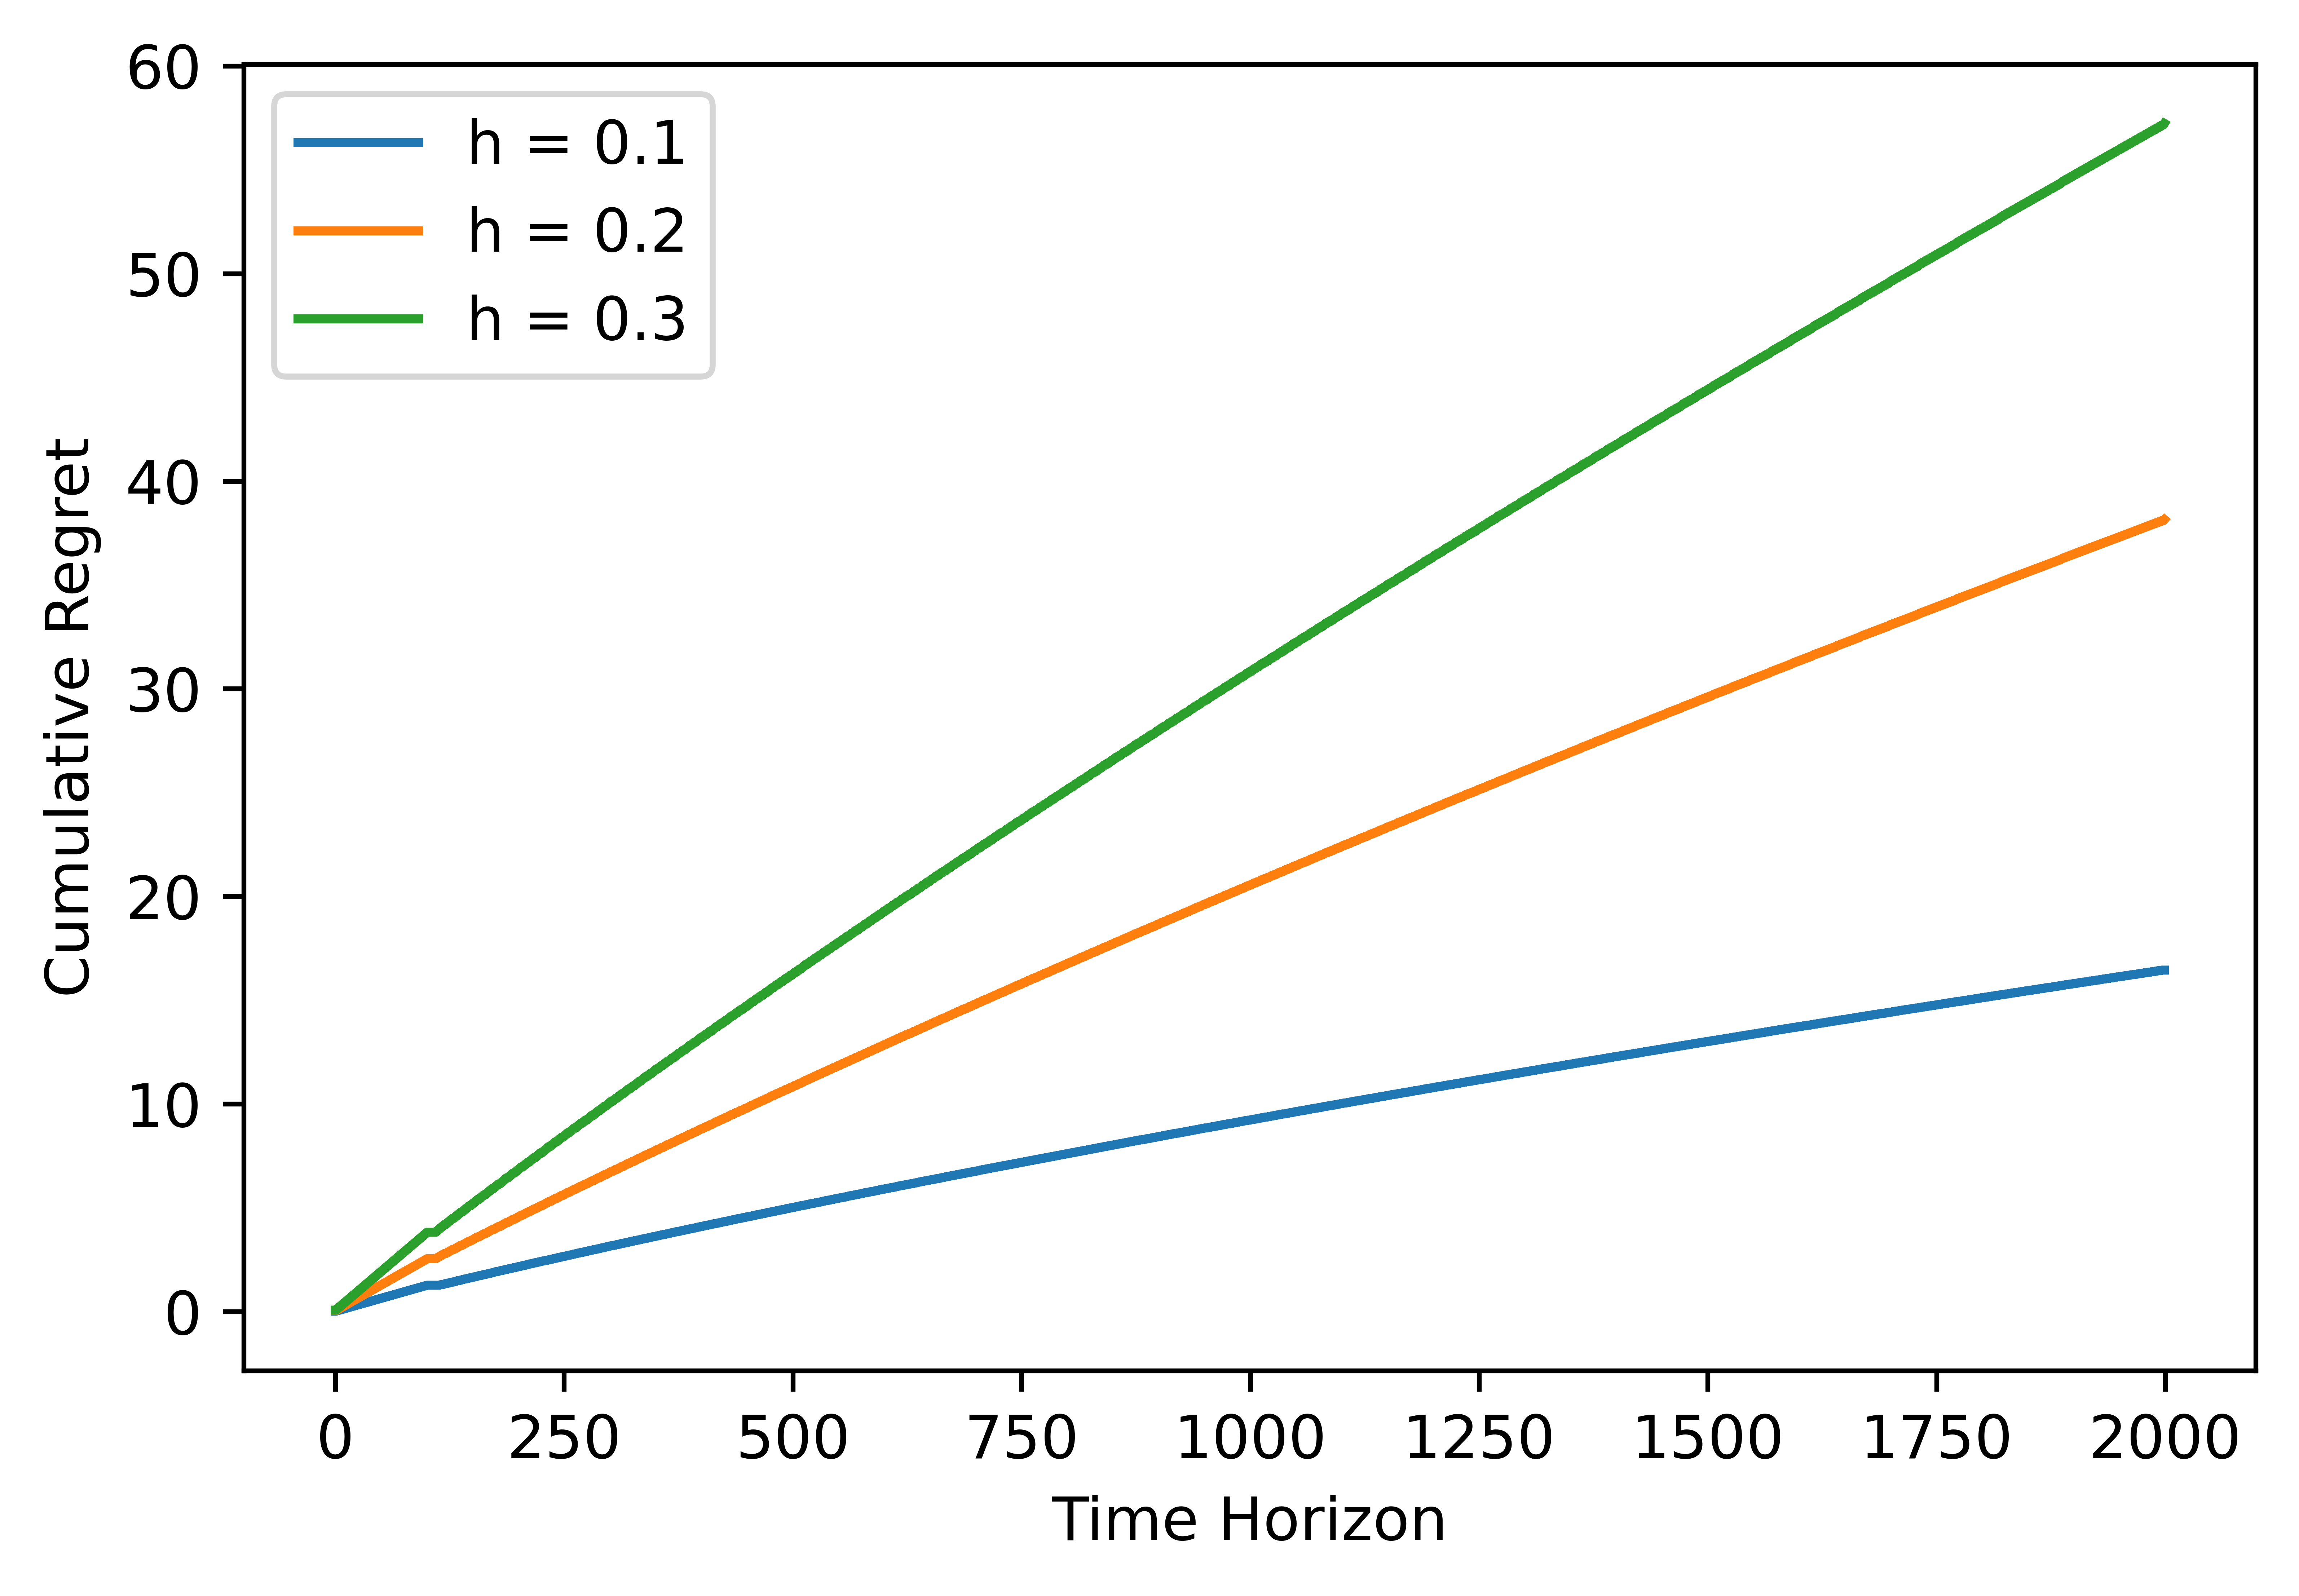

In [137]:
#regret_t = [sum(bandit[i].[j])/2 for j in range(len(bandit[1].regret_list))]
#print(len(avg_regret))
#regret_final = [np.mean([avg_regret[i][k] for i in range(len(avg_regret))]) for k in range(config['T'])]
x=np.arange(2000)

#print(avg_regret)

plt.figure(dpi=1200)
print(len(avg_regret_list))

plot_data = np.transpose(np.array(avg_regret_list)).reshape((2000,3))
#x_axis = np.arange(len(plot_data))
plt.plot(x,plot_data)
# plt.plot(x_axis,plot_min)
# plt.plot(x_axis,plot_max)
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.legend(['h = 0.1','h = 0.2','h = 0.3'])

In [167]:
def main_p(M,c,K,h,c1,L):
    #Simulation
    # different h, K, M, mu, sigma, c  
    # when c is not 0, 
    config = {}
    config['T'] = 2000
    config['L'] = L
    config['M'] = M
    config['c'] = c
    config['K'] = K
    config['c1'] = c1
    config['h'] = h
    config['scale'] = 0.2
    config['mu'] = np.ones((config['M'], config['K']))
    print(config['mu'])
    for k in range(config['K']):
        config['mu'][:,k] = np.linspace(0.1,config['h']+(k+1)*config['h']/config['K'],config['M'])
    config['sigma'] = config['scale']*np.ones((config['M'], config['K']))
    mu = config['mu']
    #mu = np.array(sorted(mu, reverse=True))
    print(mu)
    #bandit = MultiArmedBandit(num_arms, true_reward_means)
    T = config['T']
    num_agents =config['M']
    L = config['L']
    para = 0.6
    tau = 1
    #P = np.zeros((num_agents, num_arms))
    environment = Environment(config)
    #print(num_arms)
    itr = 20
    avg_regret = []
    for iteration in range(itr):
        bandit = []
        for player in range(config['M']):
            bandit.append(LocalMAB(num_agents, config['K']))

        #burn-in period  
        for t in range(L):
            arms = []
            for player in range(config['M']):
                chosen_action = t % config['K'] 
                arms.append(chosen_action)
            reward, G = environment.draw(arms)  # Simulate reward with Gaussian noise
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            for i in range(len(neighbors)):
                tmp = np.zeros(len(neighbors))
                neighbors[i].append(i)
                for j in range(len(neighbors)):
                    if j in neighbors[i]:
                        tmp[j] = 1
                        neighbors[j].append(i)
                        bandit[i].comm_reward[j] = bandit[j].q_local
                        bandit[i].comm_counts[j] = bandit[j].counts_local
                        bandit[i].tmp[j] = t
                    else:
                        tmp[j] = 0
                if t > 0:
                    bandit[i].P = [((t-1)*bandit[i].P[j] + tmp[j])/t for j in range(config['M'])]
                else:
                    bandit[i].P = tmp 
                for j in range(len(neighbors)):
                    if bandit[i].P[j] > 0:
                        bandit[i].P1[j] = 1/config['M']
                    else:
                        bandit[i].P1[j] = 0
            for i in range(config['M']):
                bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
                bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
                bandit[i].regret_list.append(bandit[i].regret)

        for k in range(config['K']):
            for i in range(config['M']):
                bandit[i].q_network[k] = sum([((config['M']/len(bandit[i].comm_reward))*bandit[i].P1[j] * bandit[i].comm_reward[j][k]) for j in bandit[i].comm_reward])

        i = 0
        #print("Estimated action values:", bandit[i].q_network)
        #print("Total reward:", bandit[i].total_reward)
        #print("maintained matrix:", bandit[i].P)

        #learning period 
        r = 0
        for t in range(L, T):
            arms = []
            for i in range(config['M']):
                flag = False
                for k in range(config['K']):
                    if bandit[i].counts_local[k] < bandit[i].counts_network[k] - config['K']:
                        flag = True
                chosen_action = bandit[i].choose_action(t, flag,config['c1'])
                arms.append(chosen_action)
                if chosen_action == 0:
                    r+=1
            reward, G = environment.draw(arms)  # Simulate reward with Gaussian noise
            neighbors = []
            for line in nx.generate_adjlist(G):
                neighbors.append(list(map(int,str(line).split(" "))))
            for i in range(len(neighbors)):
                tmp = np.zeros(len(neighbors))
                neighbors[i].append(i)
                for j in range(len(neighbors)):
                    if j in neighbors[i]:
                        tmp[j] = 1
                        neighbors[j].append(i)
                        bandit[i].comm_reward[j] = bandit[j].q_local
                        bandit[i].comm_counts[j] = bandit[j].counts_local
                        bandit[i].comm_reward_network[j] = bandit[j].q_network
                        bandit[i].comm_counts_network[j] = bandit[j].counts_network
                        bandit[i].tmp[j] = t
                    else:
                        tmp[j] = 0
                if t > 0:
                    bandit[i].P = [((t-1)*bandit[i].P[j] + tmp[j])/t for j in range(config['M'])]
                else:
                    bandit[i].P = tmp 
                for j in range(len(neighbors)):
                    if bandit[i].P[j] > 0:
                        bandit[i].P1[j] = (config['M'])/((config['M'])**2)
                    else:
                        bandit[i].P1[j] = 0
            for i in range(config['M']):
                bandit[i].update(arms[i], reward[i], mu[i,arms[i]])
                bandit[i].update_global(arms[i], reward[i])
                bandit[i].regret += mu[i,config['K']-1] - mu[i,arms[i]]
                bandit[i].regret_list.append(bandit[i].regret)
        regret_t = [np.mean([bandit[i].regret_list[j] for i in range(config['M'])]) for j in range(len(bandit[1].regret_list))]
        avg_regret.append(regret_t)
        
        return avg_regret



[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1    0.1   ]
 [0.1125 0.125 ]
 [0.125  0.15  ]
 [0.1375 0.175 ]
 [0.15   0.2   ]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1   0.1  ]
 [0.15  0.175]
 [0.2   0.25 ]
 [0.25  0.325]
 [0.3   0.4  ]]


/var/folders/tt/xtqbgt9s3pv16nh1_s_q2zc80000gn/T/ipykernel_51490/2909422124.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  self.q_var = [np.sqrt(c1*np.log(t)/self.counts_network[i]) for i in range(len(self.counts_local))]


[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1    0.1   ]
 [0.1875 0.225 ]
 [0.275  0.35  ]
 [0.3625 0.475 ]
 [0.45   0.6   ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3


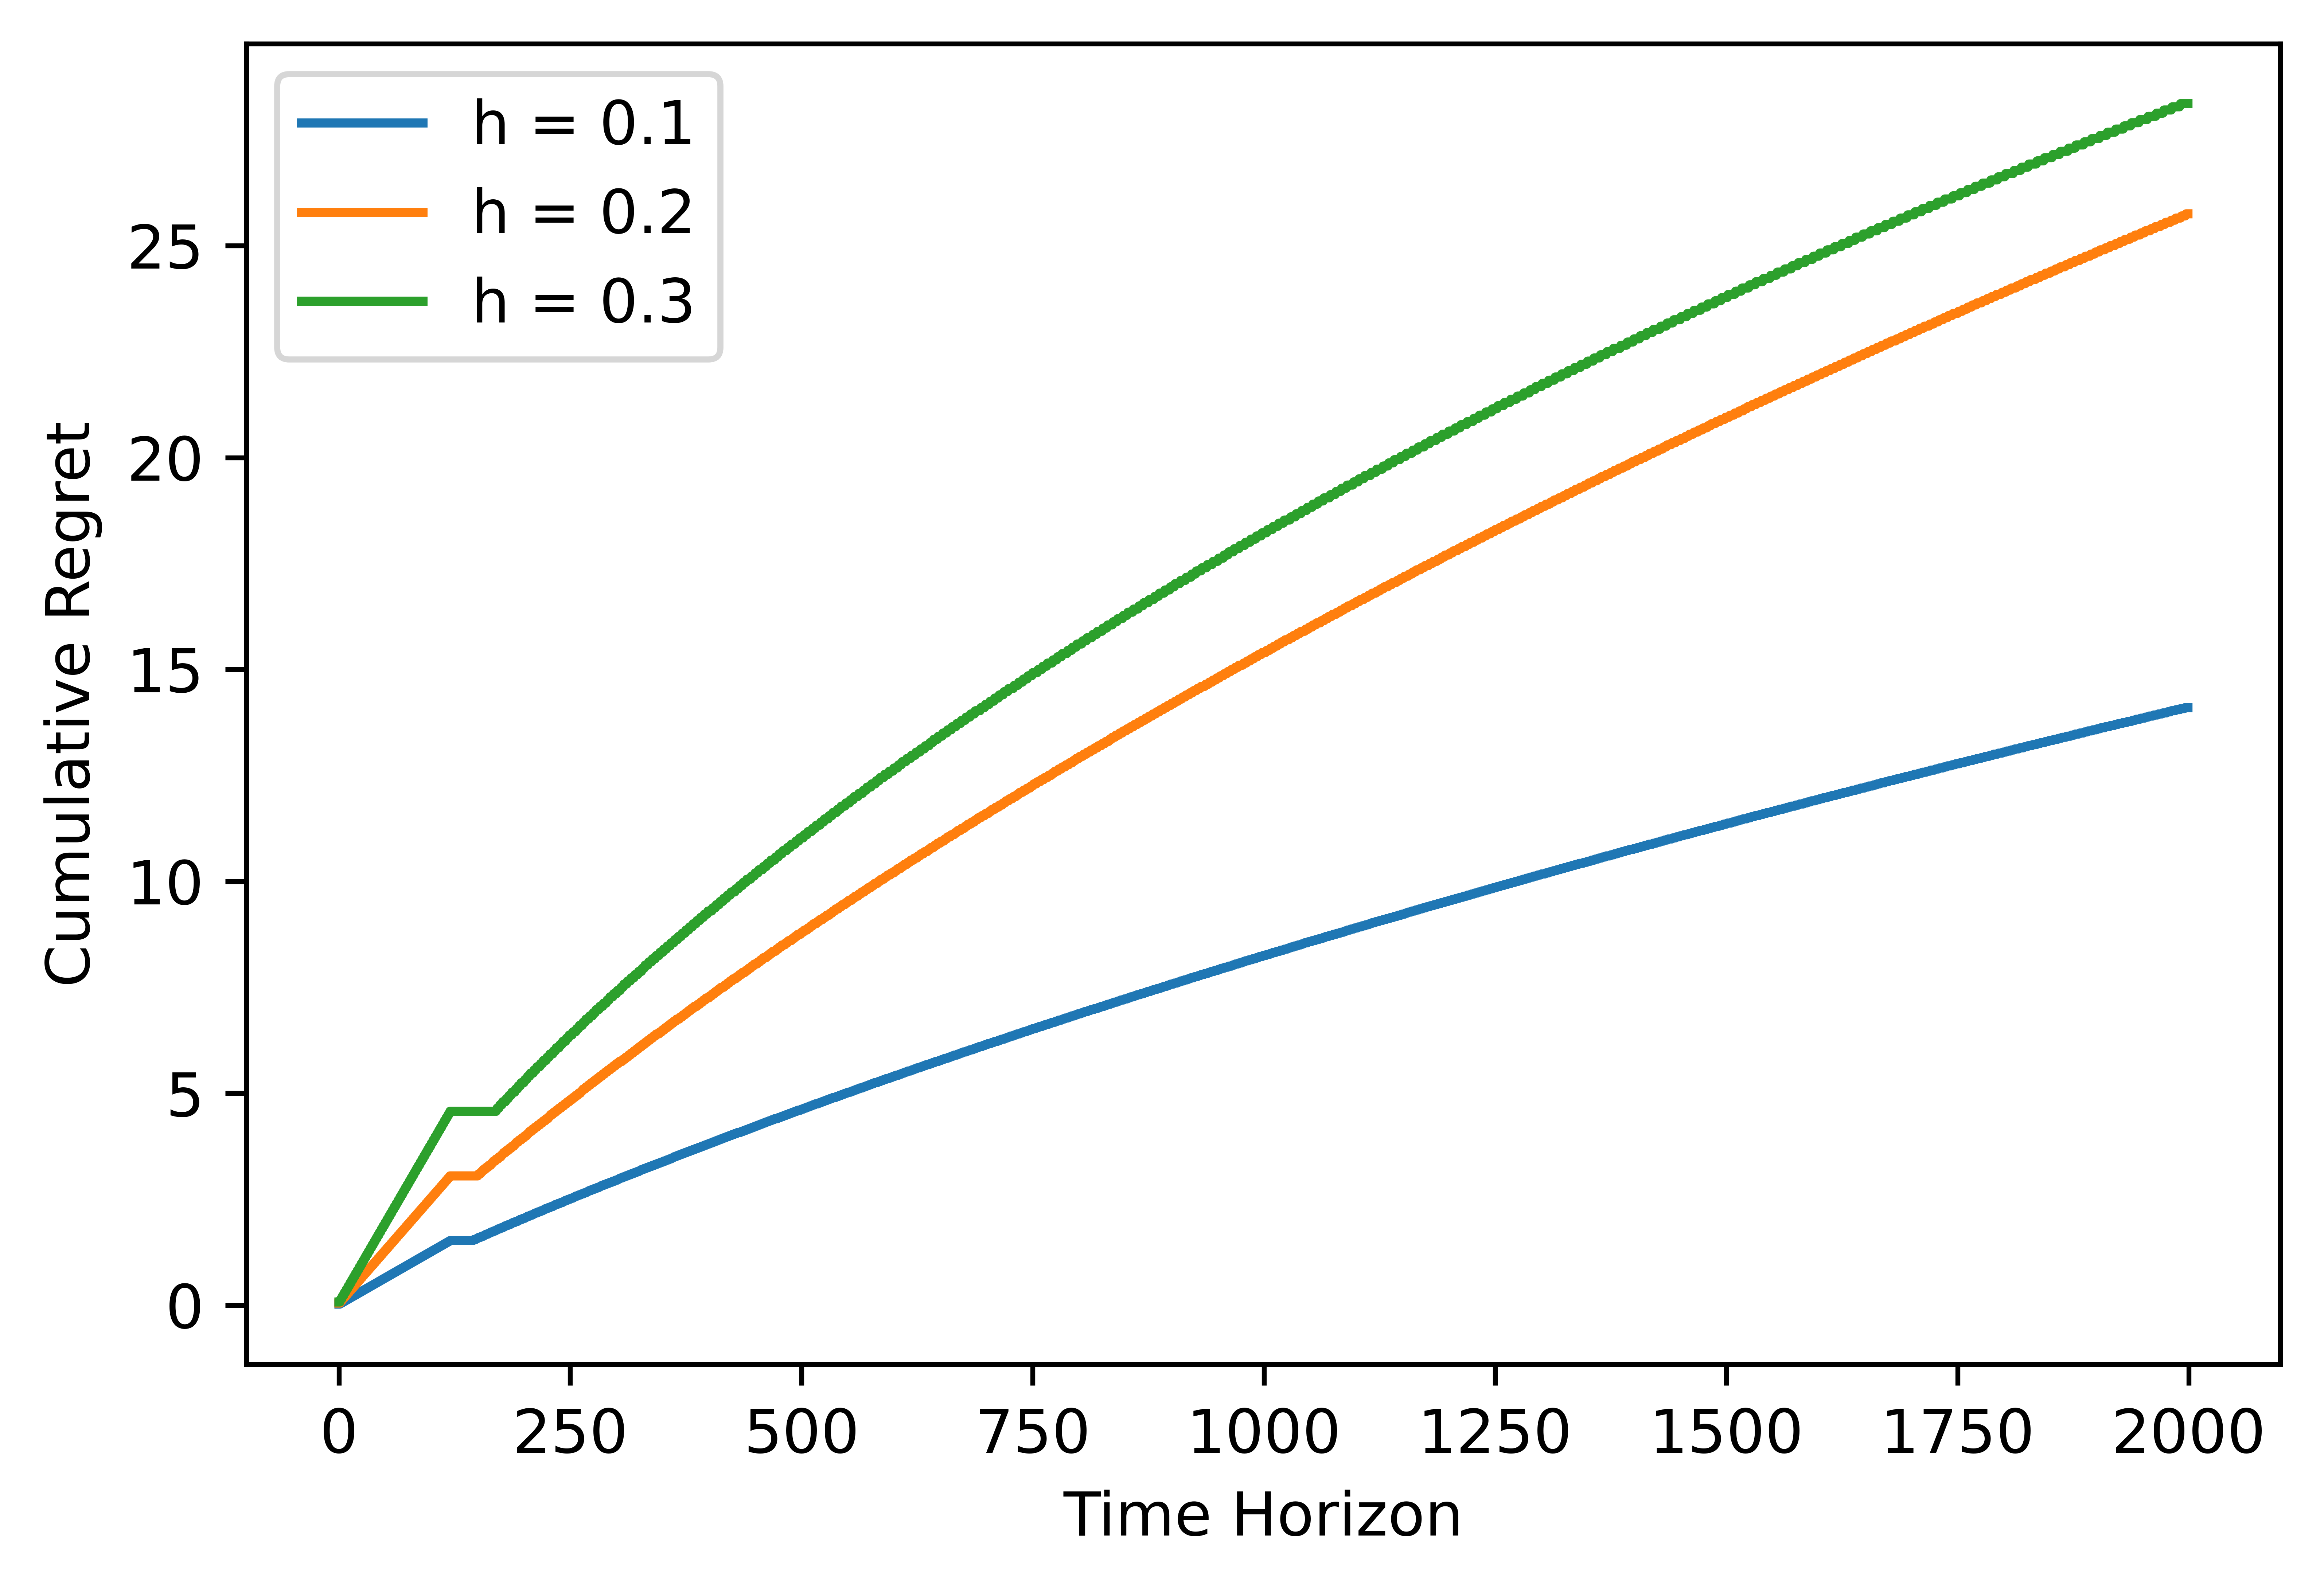

In [171]:
#h and k needs to be compared against again 
h_set = [0.1,0.2,0.3]
avg_regret_list = []
for h in h_set:
    tmp_regret = main_p(5,0.9, 2, h, 1, 120)
    avg_regret_list.append(tmp_regret)
    
#regret_t = [sum(bandit[i].[j])/2 for j in range(len(bandit[1].regret_list))]
#print(len(avg_regret))
#regret_final = [np.mean([avg_regret[i][k] for i in range(len(avg_regret))]) for k in range(config['T'])]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3


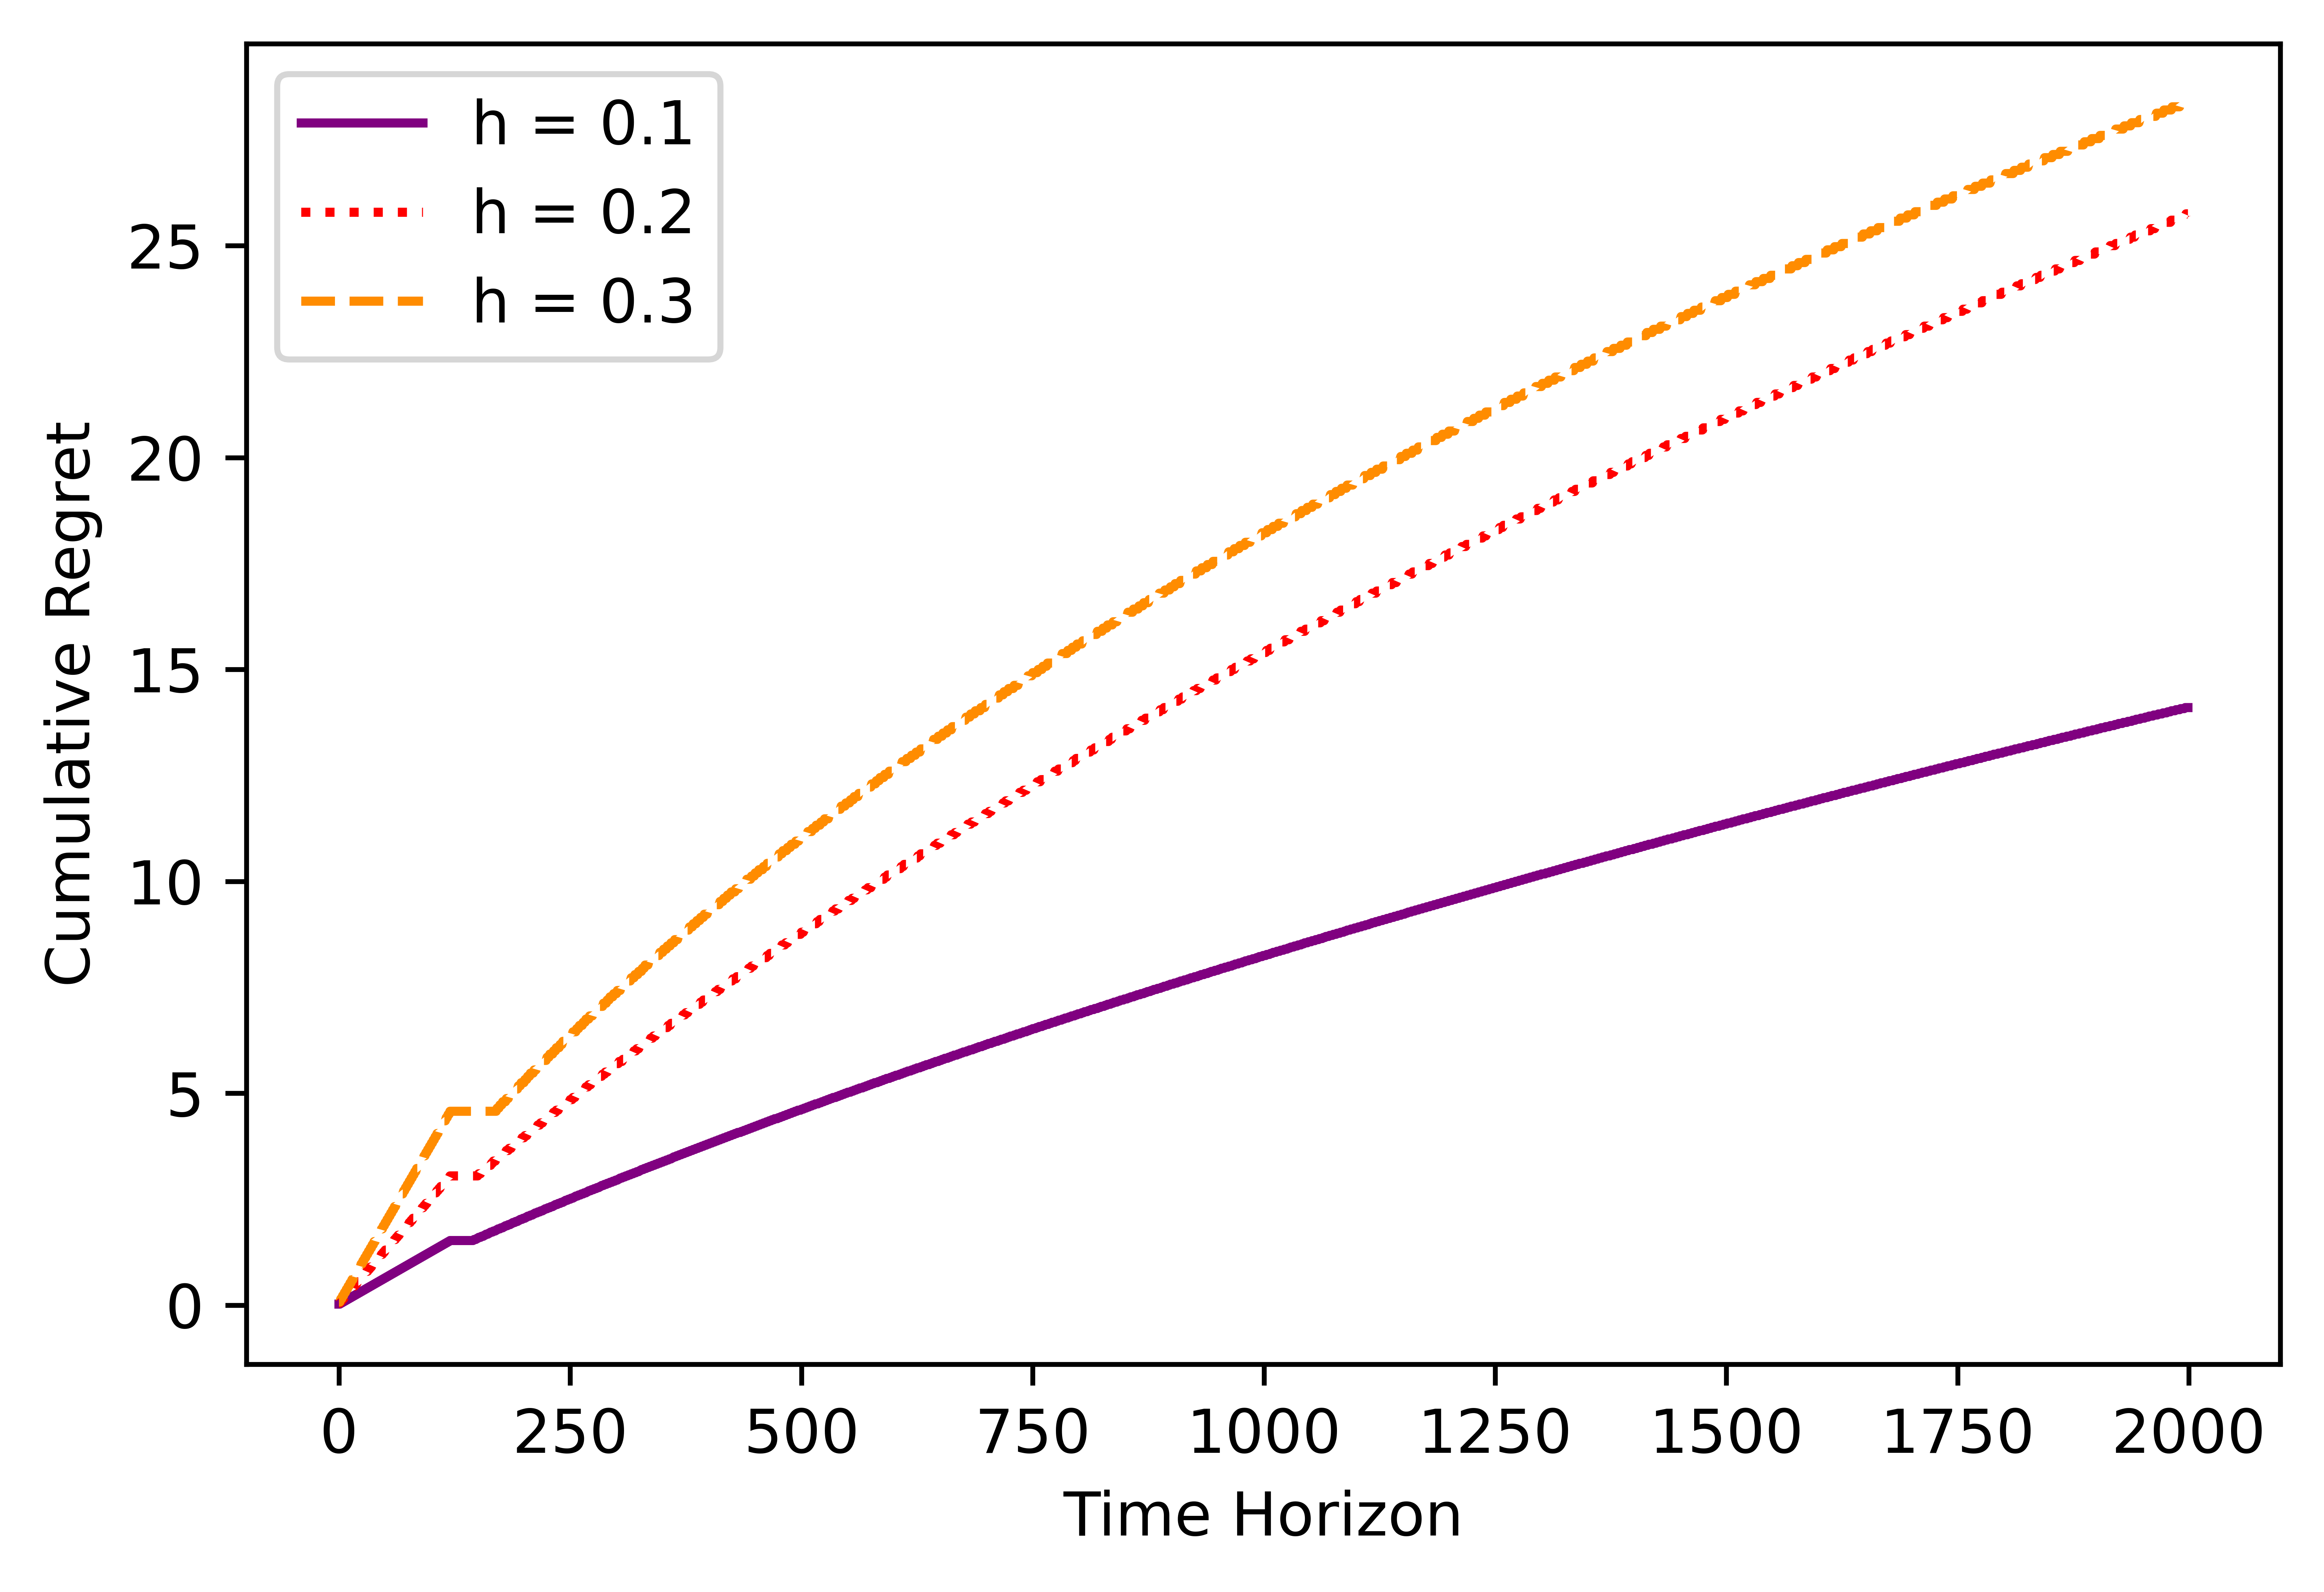

In [177]:
x=np.arange(2000)

#print(avg_regret)

plt.figure(dpi=1200)
print(len(avg_regret_list))

plot_data = np.transpose(np.array(avg_regret_list)).reshape((2000,3))
#x_axis = np.arange(len(plot_data))
lw = ['--',':','solid']
color = ['darkorange','red','purple']
for column in range(len(avg_regret_list)):
    plt.plot(x,plot_data[:,column], linestyle = lw[2-column], color = color[2-column])
# plt.plot(x_axis,plot_min)
# plt.plot(x_axis,plot_max)
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.legend(['h = 0.1','h = 0.2','h = 0.3'])

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1    0.1   ]
 [0.1125 0.125 ]
 [0.125  0.15  ]
 [0.1375 0.175 ]
 [0.15   0.2   ]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[[0.1        0.1        0.1       ]
 [0.10833333 0.11666667 0.125     ]
 [0.11666667 0.13333333 0.15      ]
 [0.125      0.15       0.175     ]
 [0.13333333 0.16666667 0.2       ]]


/var/folders/tt/xtqbgt9s3pv16nh1_s_q2zc80000gn/T/ipykernel_51490/2909422124.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  self.q_var = [np.sqrt(c1*np.log(t)/self.counts_network[i]) for i in range(len(self.counts_local))]


[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[[0.1     0.1     0.1     0.1    ]
 [0.10625 0.1125  0.11875 0.125  ]
 [0.1125  0.125   0.1375  0.15   ]
 [0.11875 0.1375  0.15625 0.175  ]
 [0.125   0.15    0.175   0.2    ]]
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
[[0.1   0.1   0.1   0.1   0.1  ]
 [0.105 0.11  0.115 0.12  0.125]
 [0.11  0.12  0.13  0.14  0.15 ]
 [0.115 0.13  0.145 0.16  0.175]
 [0.12  0.14  0.16  0.18  0.2  ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


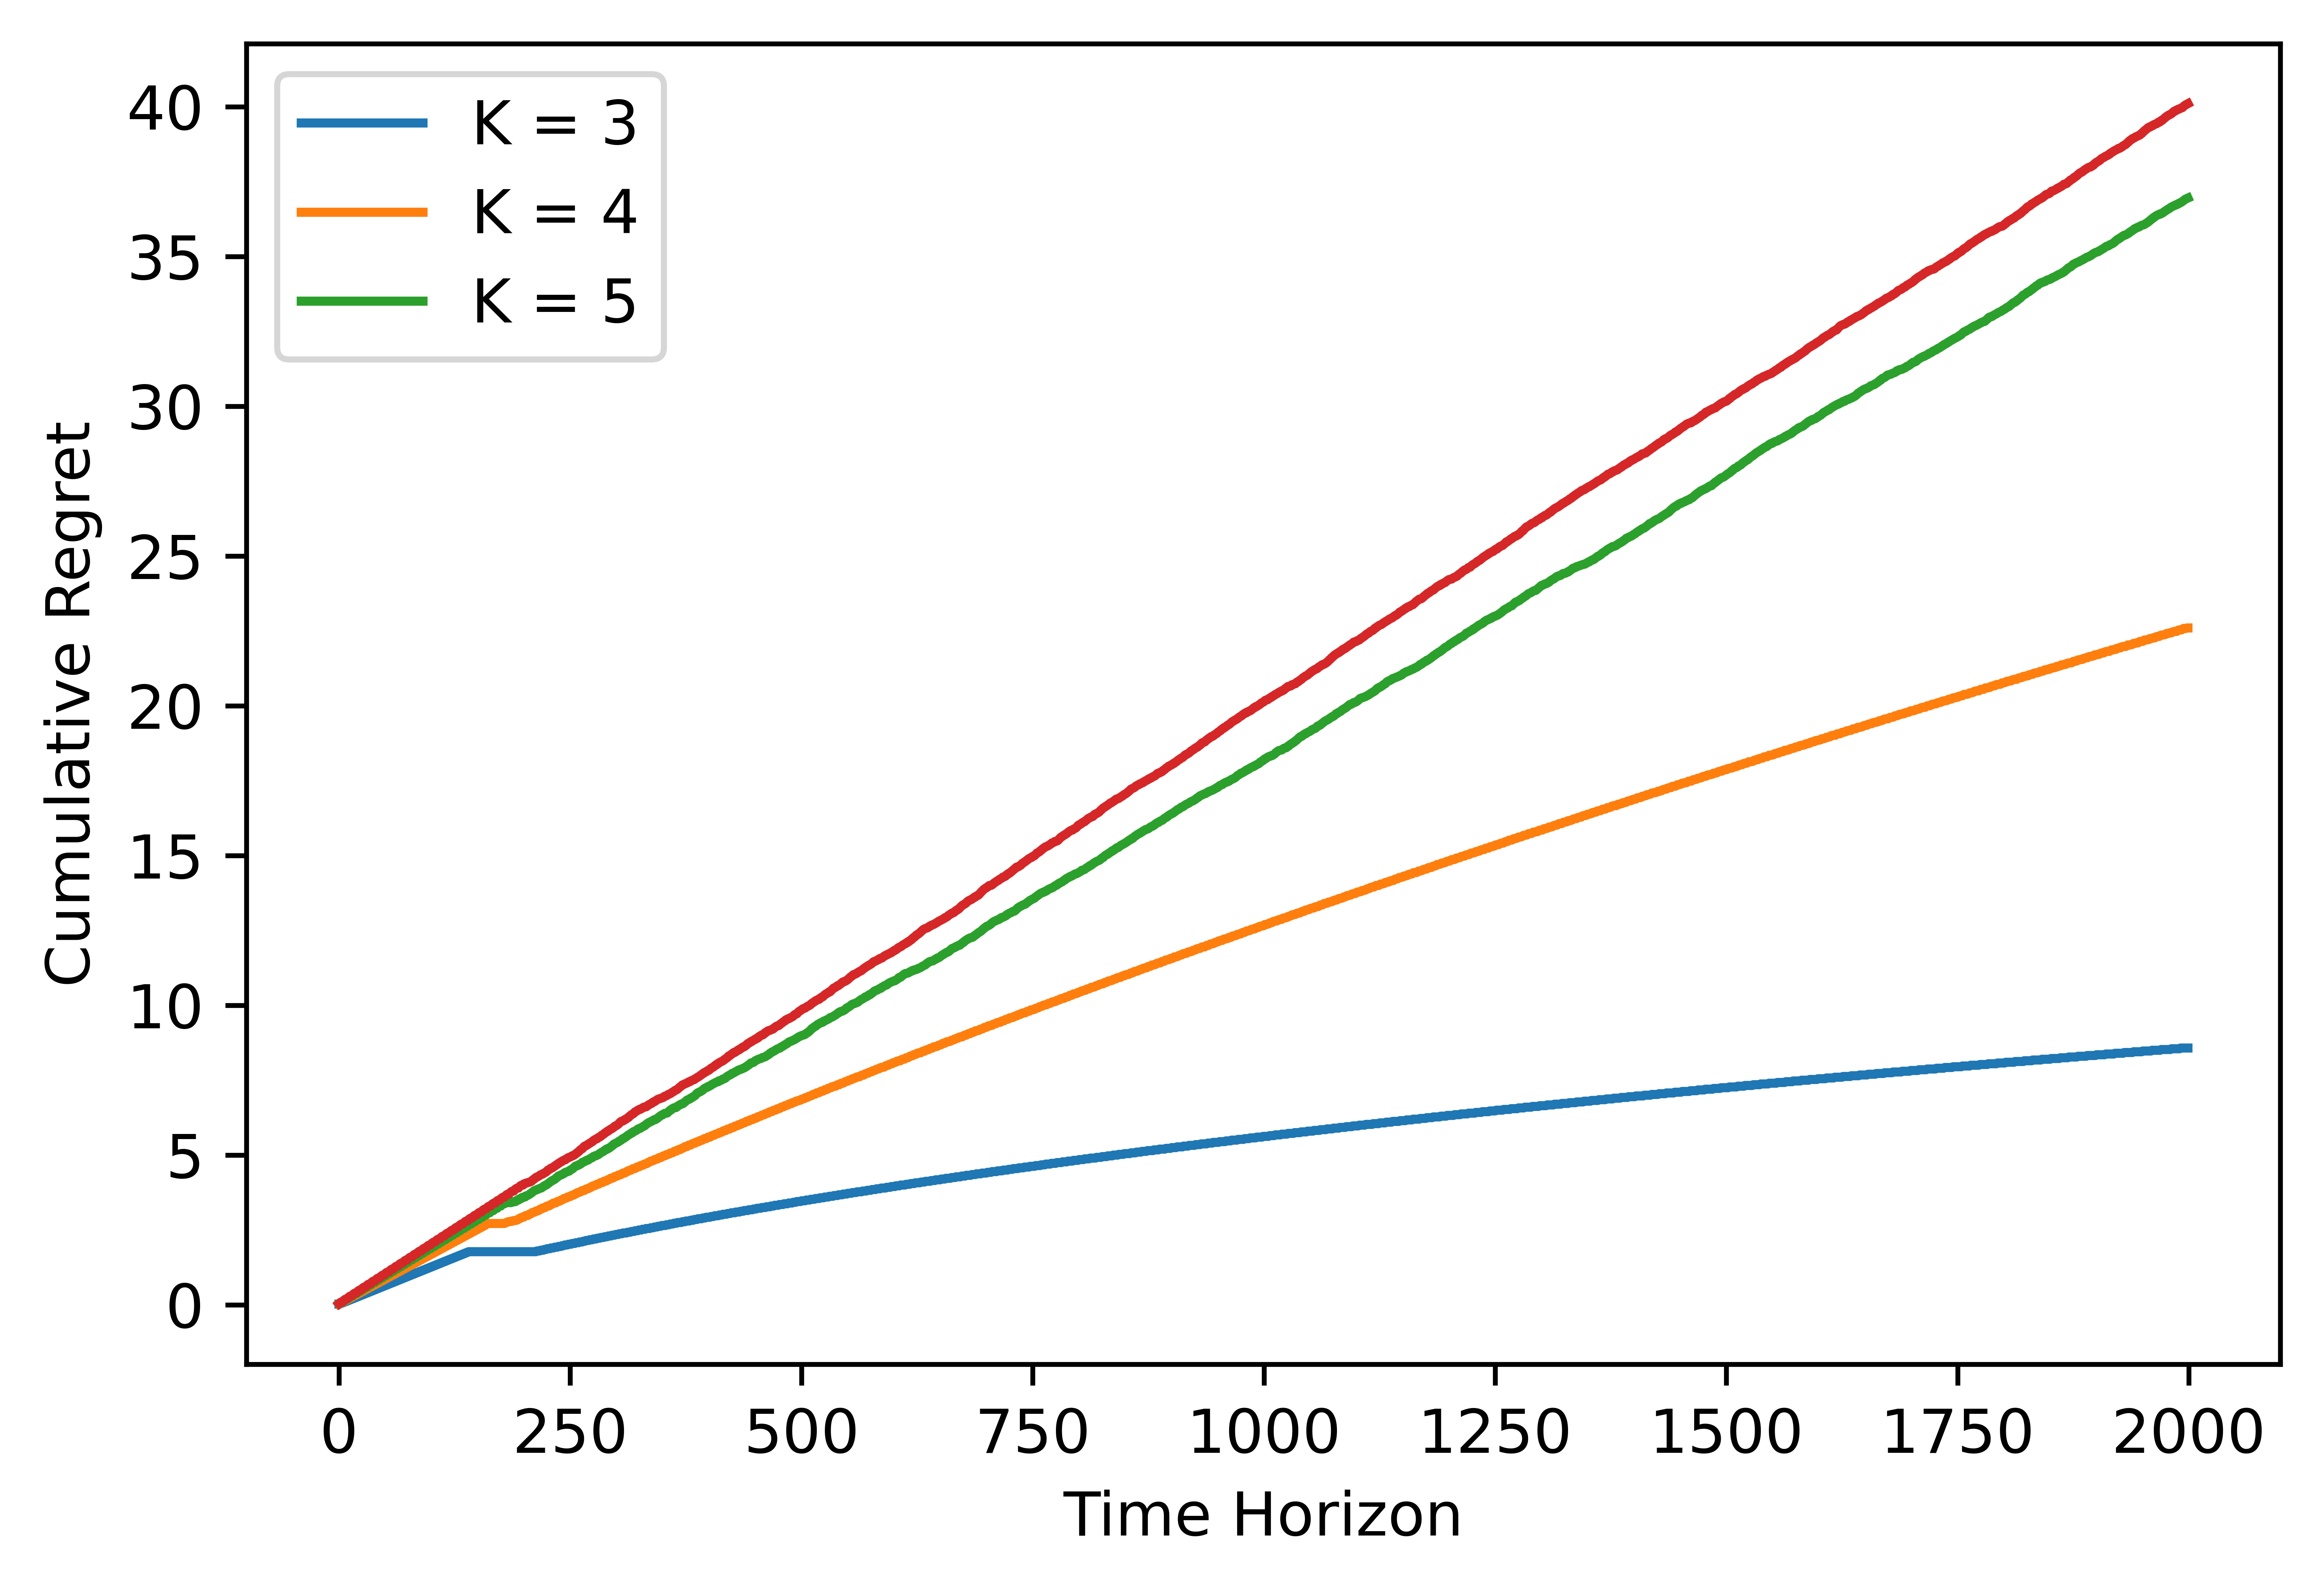

In [182]:
K_set = [2, 3, 4, 5]
avg_regret_list = []
for k in K_set:
    tmp_regret = main_p(5,0.9, k, 0.1, 0.5+k*0.05, 100+k*20)
    avg_regret_list.append(tmp_regret)
    
#regret_t = [sum(bandit[i].[j])/2 for j in range(len(bandit[1].regret_list))]
#print(len(avg_regret))
#regret_final = [np.mean([avg_regret[i][k] for i in range(len(avg_regret))]) for k in range(config['T'])]



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


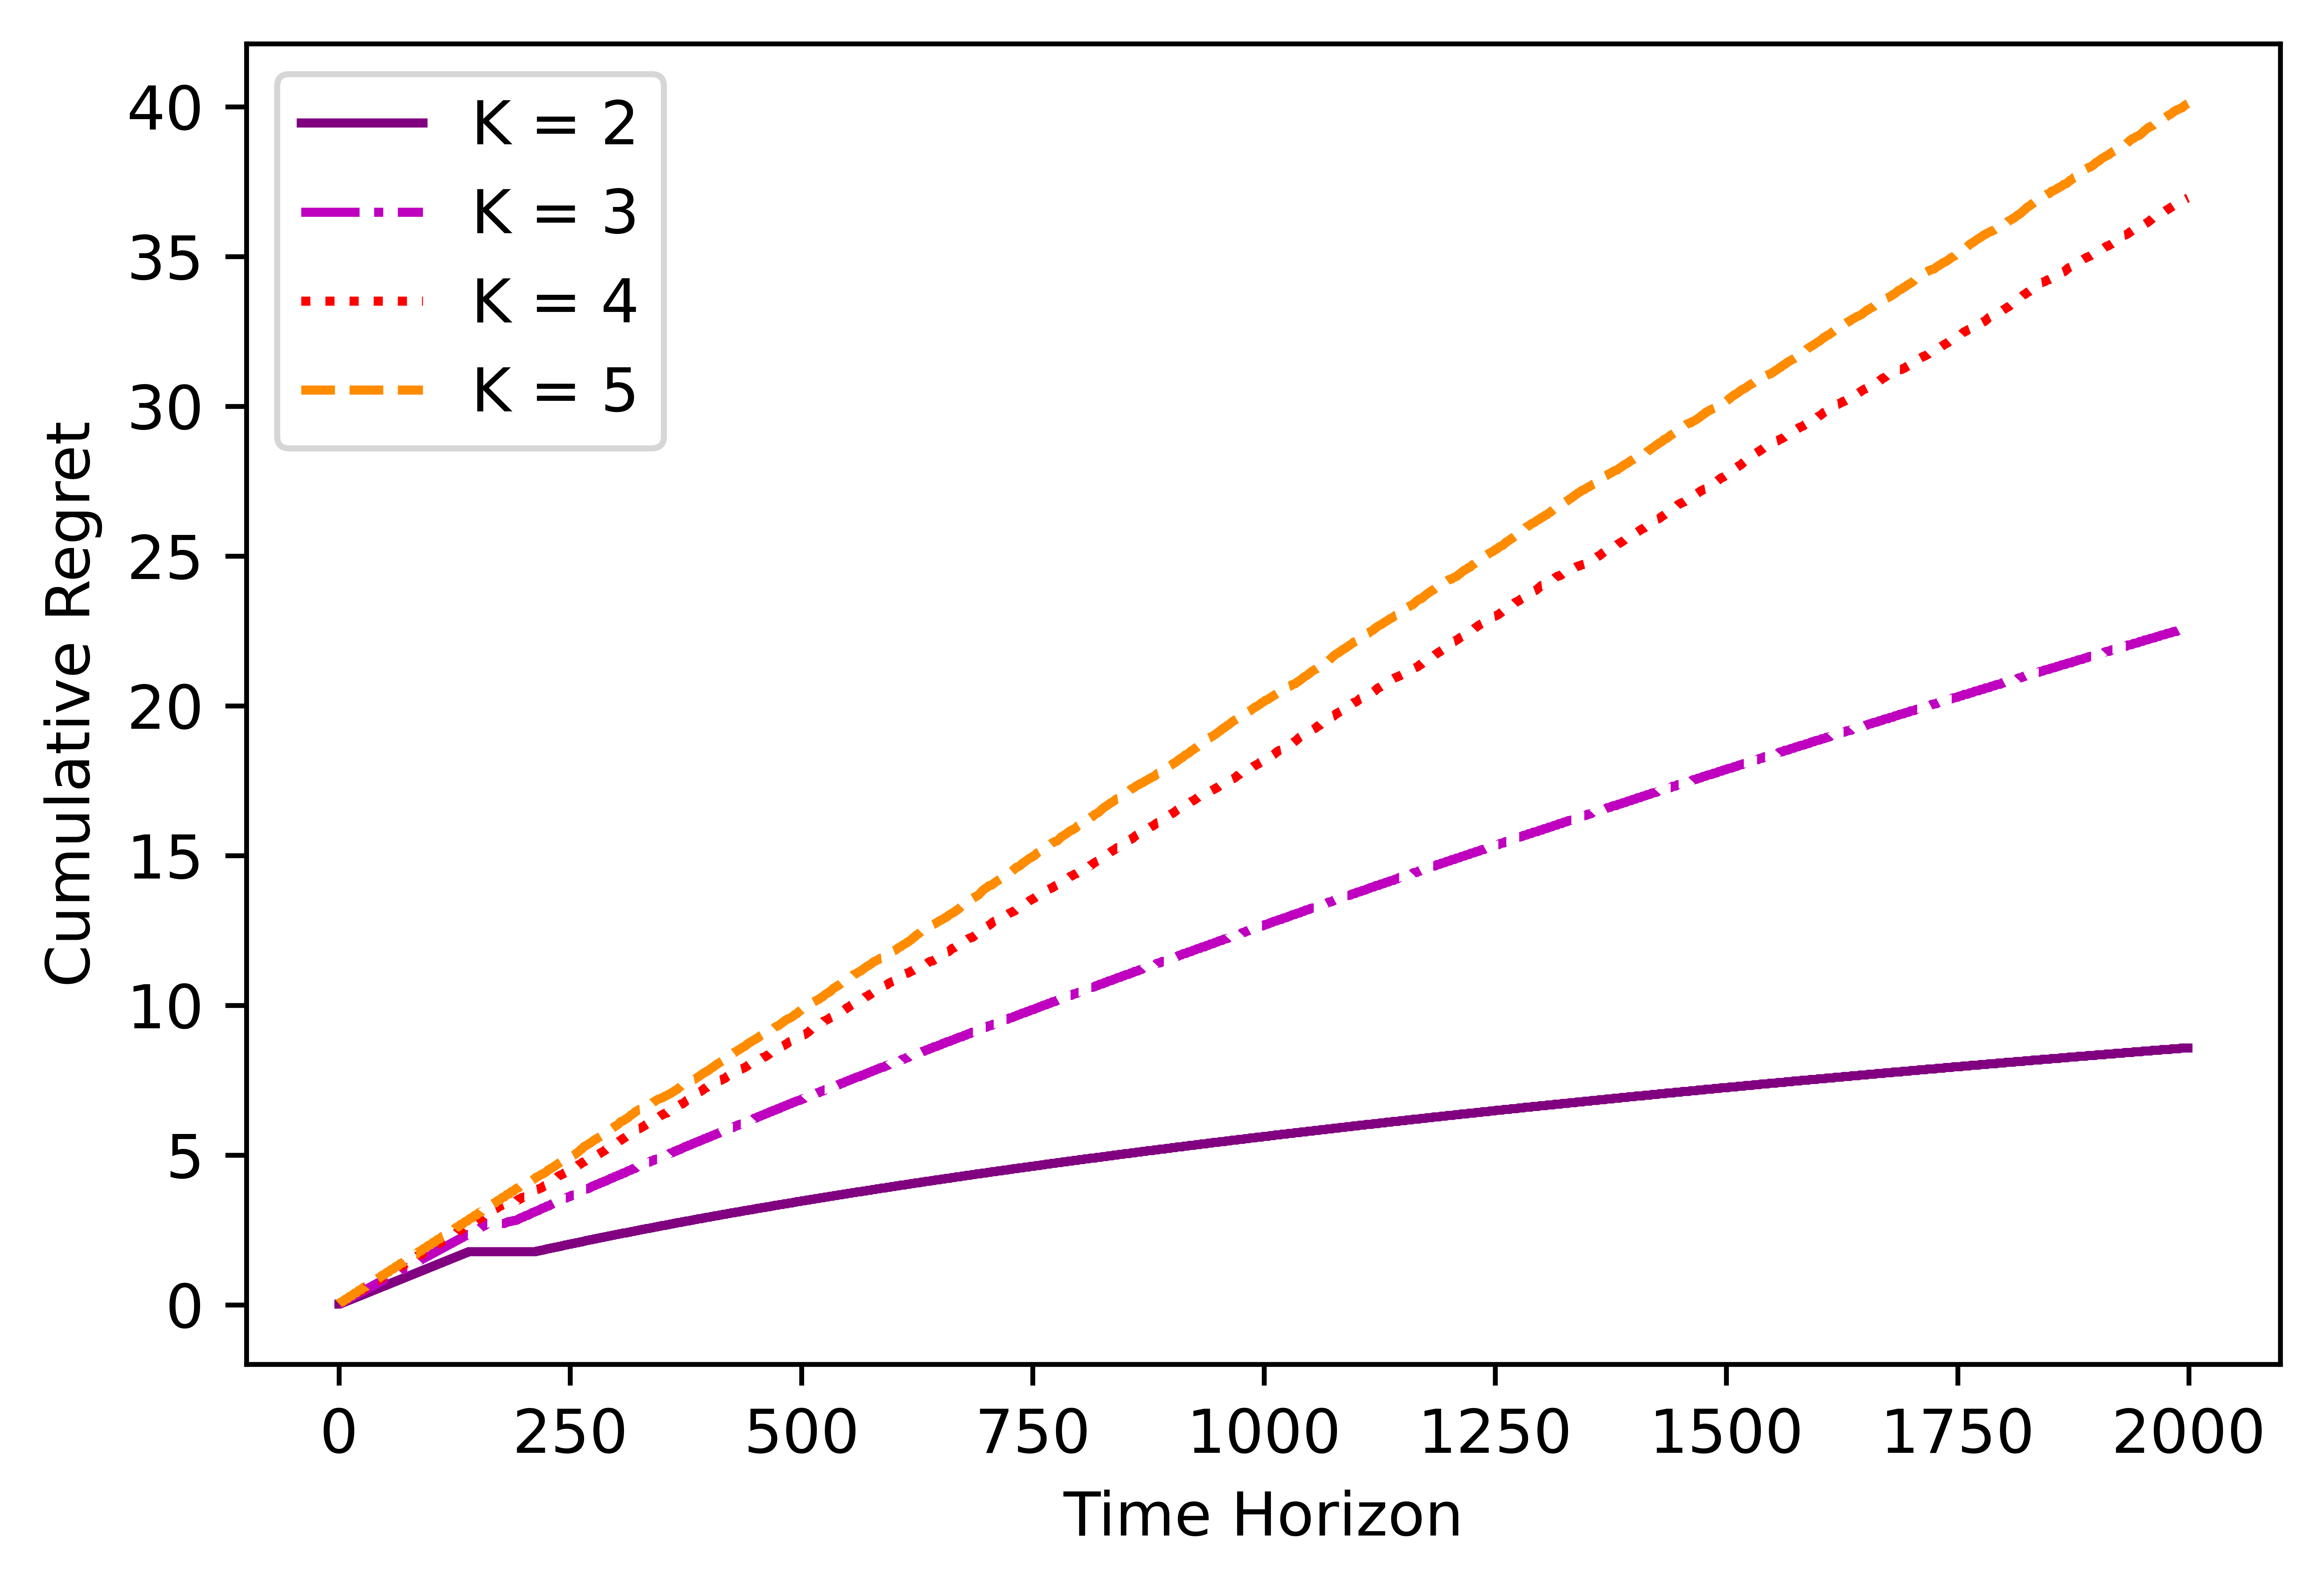

In [184]:
x=np.arange(2000)

#print(avg_regret)

plt.figure(dpi=1200)


plot_data = np.transpose(np.array(avg_regret_list)).reshape((2000,4))
lw = ['--',':','dashdot','solid']
color = ['darkorange','red','m','purple']
for column in range(len(avg_regret_list)):
    plt.plot(x,plot_data[:,column], linestyle = lw[3-column], color = color[3-column])
# plt.plot(x_axis,plot_min)
# plt.plot(x_axis,plot_max)
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.legend(['K = 2', 'K = 3','K = 4','K = 5'])

[[1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1   0.1  ]
 [0.125 0.15 ]
 [0.15  0.2  ]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1    0.1   ]
 [0.1125 0.125 ]
 [0.125  0.15  ]
 [0.1375 0.175 ]
 [0.15   0.2   ]]


/var/folders/tt/xtqbgt9s3pv16nh1_s_q2zc80000gn/T/ipykernel_51490/2909422124.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  self.q_var = [np.sqrt(c1*np.log(t)/self.counts_network[i]) for i in range(len(self.counts_local))]


[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1        0.1       ]
 [0.10714286 0.11428571]
 [0.11428571 0.12857143]
 [0.12142857 0.14285714]
 [0.12857143 0.15714286]
 [0.13571429 0.17142857]
 [0.14285714 0.18571429]
 [0.15       0.2       ]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[0.1        0.1       ]
 [0.10555556 0.11111111]
 [0.11111111 0.12222222]
 [0.11666667 0.13333333]
 [0.12222222 0.14444444]
 [0.12777778 0.15555556]
 [0.13333333 0.16666667]
 [0.13888889 0.17777778]
 [0.14444444 0.18888889]
 [0.15       0.2       ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


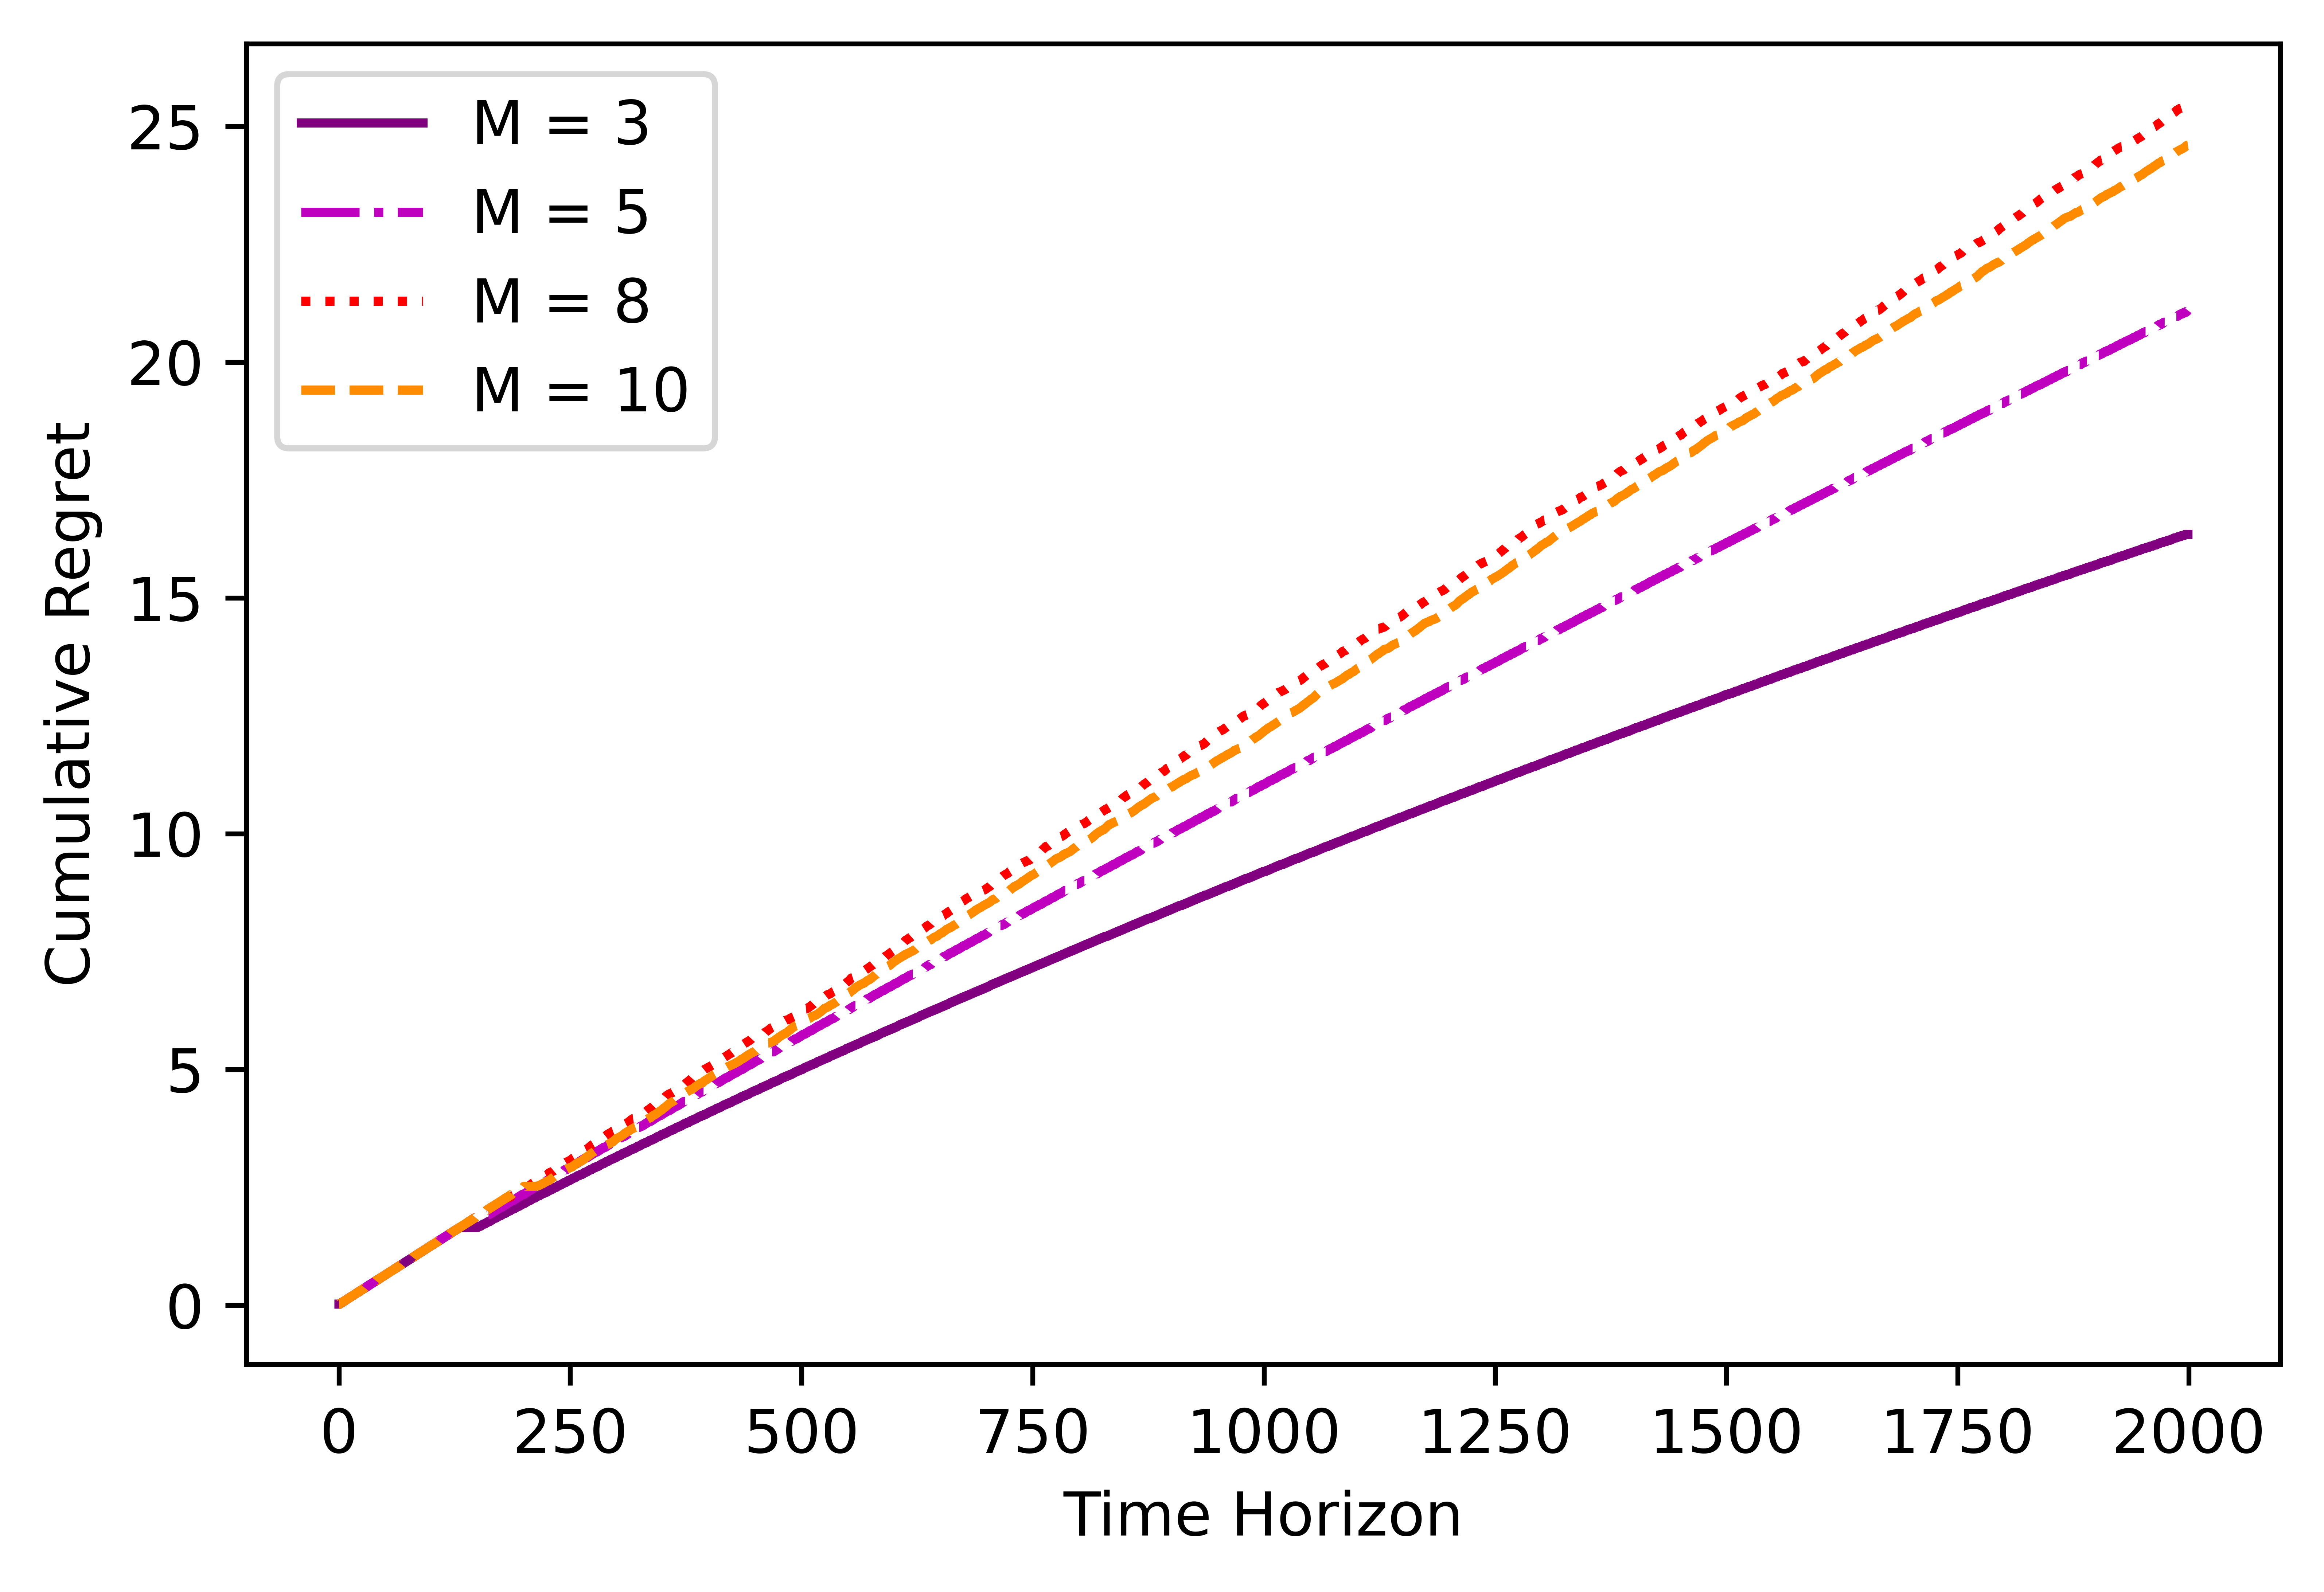

In [188]:
M_set = [3, 5, 8, 10]
avg_regret_list = []
for M in M_set:
    tmp_regret = main_p(M,0.9, 2, 0.1,0.5+M*0.5, 100+M*10)
    avg_regret_list.append(tmp_regret)
    
#regret_t = [sum(bandit[i].[j])/2 for j in range(len(bandit[1].regret_list))]
#print(len(avg_regret))
#regret_final = [np.mean([avg_regret[i][k] for i in range(len(avg_regret))]) for k in range(config['T'])]
x=np.arange(2000)

#print(avg_regret)

plt.figure(dpi=1200)


plot_data = np.transpose(np.array(avg_regret_list)).reshape((2000,4))
lw = ['--',':','dashdot','solid']
color = ['darkorange','red','m','purple']
for column in range(len(avg_regret_list)):
    plt.plot(x,plot_data[:,column], linestyle = lw[3-column], color = color[3-column])
# plt.plot(x_axis,plot_min)
# plt.plot(x_axis,plot_max)
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.legend(['M = 3', 'M = 5','M = 8','M = 10'])


